# **Newborn Birth Weight Prediction using Deep Learning in PyTorch**

# **Introduction**
This project aims to develop a machine learning model using PyTorch to predict the exact birth weight of a baby based on a comprehensive set of maternal factors. Birth weight is a critical indicator of neonatal health, with significant implications for both short-term and long-term outcomes. Accurately predicting birth weight can enable healthcare professionals to identify and manage at-risk pregnancies more effectively.

The dataset used includes various features related to the health, demographic, and lifestyle characteristics of pregnant women. The model is structured as a linear regression problem, where the goal is to predict the precise birth weight in grams. Extensive data preprocessing, including normalization and feature engineering, is employed to enhance model performance. The linear regression model is trained and evaluated using metrics such as Mean Squared Error (MSE) and R-squared, providing a clear measure of prediction accuracy.

This project demonstrates the potential of deep learning techniques in predicting continuous health outcomes, offering valuable insights into the maternal factors that influence birth weight. The results highlight the model's ability to make accurate predictions, which could be instrumental in improving prenatal care and reducing the incidence of complications related to abnormal birth weights.

# **Imports**
Since the following project is done on PyTorch, we will import some basic modules right now. Further down the line, we will have to import more libraries for various reasons.
For readability and ease of understanding, only basic imports have been made in the cell below.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# **Data Preprocessing**
### **About the Data**
The Dataset used was published by the [National Centre for Health Statistics](https://www.cdc.gov/nchs/data_access/vitalstatsonline.htm), which is an official website of the United States Government. The Dataset contains detailed information of all births recorded in the US in the year of 2018.
You can also access the dataset from [Kaggle](https://www.kaggle.com/datasets/des137/us-births-2018/data).

The dataset itself is around 532 MegaBytes in size, which is pretty large enough for us to train an accurate model. There are around 1 Million records in the dataset and 55 columns.

However, not all 55 columns give us relevant information to train our model and not all columns are ready to use in training, which is why we will have to preprocess the data.

Let us start with a few imports below.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("/content/US_births(2018).csv")
df.head()

<ipython-input-3-32438d0537cf>:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/US_births(2018).csv")


,ATTEND,BFACIL,BMI,CIG_0,DBWT,DLMP_MM,DLMP_YY,DMAR,DOB_MM,DOB_TT,...,PRIORDEAD,PRIORLIVE,PRIORTERM,PWgt_R,RDMETH_REC,RESTATUS,RF_CESAR,RF_CESARN,SEX,WTGAIN
0,1,1,30.7,0,3657,4,2017,1,1,1227,...,0,1,2,190,1,2,N,0,M,41
1,1,1,33.3,2,3242,99,9999,2,1,1704,...,0,2,0,188,4,2,Y,2,F,0
2,1,1,30.0,0,3470,4,2017,1,1,336,...,0,1,0,215,1,1,N,0,M,58
3,3,1,23.7,0,3140,5,2017,2,1,938,...,0,2,0,138,1,2,N,0,F,0
4,1,1,35.5,0,2125,99,9999,1,1,830,...,0,1,4,220,3,1,N,0,M,0


In [4]:
df.shape

(3801534, 55)

As you can see from the warning above, and a peek at the dataset itself, the Dataset is not clean and not ready to use yet.
For this reason, we will have to do some data processing.

**The column names may seem to be ambiguos right now, but in case you would like to know what each column is referring to, go to this [link](https://ftp.cdc.gov/pub/Health_Statistics/NCHS/Dataset_Documentation/DVS/natality/UserGuide2018-508.pdf)**

At a first glance, we really cannot tell which features are relevant to our research and which are not. One useful way of determining this is by plotting a correlation matrix between all features in the Dataset, as shown below.

However, in order to compute a correlation matrix for a dataframe, all the features should be of a numeric datatype, which we currently do not have.
Thus, we will change datatypes for certain columns of the dataframe.

In [5]:
column_dtypes = df.dtypes
print(column_dtypes)

ATTEND           int64
BFACIL           int64
BMI            float64
CIG_0            int64
DBWT             int64
DLMP_MM          int64
DLMP_YY          int64
DMAR            object
DOB_MM           int64
DOB_TT           int64
DOB_WK           int64
DOB_YY           int64
DWgt_R           int64
FAGECOMB         int64
FEDUC            int64
FHISPX           int64
FRACE15          int64
FRACE31          int64
FRACE6           int64
ILLB_R           int64
ILOP_R           int64
ILP_R            int64
IMP_SEX         object
IP_GON          object
LD_INDL         object
MAGER            int64
MAGE_IMPFLG     object
MAR_IMP         object
MBSTATE_REC      int64
MEDUC            int64
MHISPX           int64
MM_AICU         object
MRACE15          int64
MRACE31          int64
MRACEIMP        object
MRAVE6           int64
MTRAN           object
M_Ht_In          int64
NO_INFEC         int64
NO_MMORB         int64
NO_RISKS         int64
PAY              int64
PAY_REC          int64
PRECARE    

In [6]:
# Retrieve only those columns who have a non-numeric datatype
non_numeric_columns = []
for i in range(len(column_dtypes)):
  if column_dtypes[i] == 'object':
    print(df.columns[i])
    non_numeric_columns.append(df.columns[i])

DMAR
IMP_SEX
IP_GON
LD_INDL
MAGE_IMPFLG
MAR_IMP
MM_AICU
MRACEIMP
MTRAN
RF_CESAR
SEX


<ipython-input-6-ec70ace961d6>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if column_dtypes[i] == 'object':


For convenience, I have provided the descriptions of each of these columns below:

1) DMAR = Marital Status

2) IMP_SEX = Imputed Sex ,i.e, the sex of the baby has been inferred and not actually been recorded.

3) IP_GON = Does the baby have Gonorrhea, Yes or No?

4) LD_INDL = Was labour in the pregnant mother induced, Yes or No?

5) MAGE_IMPFLG = Imputed Age of the Mother, Blank for not imputed and 1 for Imputed.

6) MAR_IMP = Mother's Marital Status Imputed, Blank for not imputed and 1 for imputed.

7) MM_AICU = Admitted to Intensive Care, Yes or No or Unknown?

8) MRACEIMP = Mother's Race Imputed

9) MTRAN = Mother Transferred from on facility to another, Yes or No or Unknown.

10) RF_CESAR = Previous Cesarean ,i.e, Has the Mother undergone a Cesarean surgery before?

11) SEX = Sex of Infant

Let us now view the unique values that occur in each of the columns for further insight into them. This will also help us decide whether to drop these columns or transform them into numeric values.

In [7]:
for i in range(len(non_numeric_columns)):
  print(non_numeric_columns[i])
  print(df[non_numeric_columns[i]].unique())
  print()

DMAR
[1 2 '2' '1' ' ']

IMP_SEX
[' ' '1']

IP_GON
['N' 'U' 'Y']

LD_INDL
['N' 'Y' 'U']

MAGE_IMPFLG
[' ' '1']

MAR_IMP
[' ' '1']

MM_AICU
['N' 'U' 'Y']

MRACEIMP
[' ' '1']

MTRAN
['N' 'Y' 'U']

RF_CESAR
['N' 'Y' 'U']

SEX
['M' 'F']



Most of these features seem to be categorical variables that can easily be modeled as numeric binary variables. Also, many of these features are a result of imputation, i.e, the information was not actually observed, but has rather been inferred.

The decision to include imputed columns in your analysis is more of an art than it is a science. Imputed data may contain inherent unintentional biases that may be learned by the model in some cases, whereas in others, indication that a certain feature has been imputed can provide additional context that can improve model performance.

For our analysis, we will be dropping a few columns from the dataset including their imputation indicator if any, depending on whether they are relevant to our study.

We will be working on each column one by one.

## **Analysing Frequency Count**

Let us first get the frequency count of all the values that occur in each of these columns.

**DMAR - Marital Status of the Mother**

In [8]:
df['DMAR'] = df['DMAR'].replace({1 : 1, 2: 2, '2': 2, '1': 1, ' ': 0})
for i in df['DMAR'].unique():
  print(str(i) + ":" + str(df['DMAR'][df['DMAR'] == i].count()))
  print()

1:2008022

2:1337429

0:456083



**IMP_SEX - Imputation Indicator of the Infant's Sex**

In [9]:
df['IMP_SEX'] = df['IMP_SEX'].replace({1 : 1, ' ': 0})
for i in df['IMP_SEX'].unique():
  print(str(i) + ":" + str(df['IMP_SEX'][df['IMP_SEX'] == i].count()))
  print()

0:3801444

1:90



**IP_GON - Infant's Gonorrhea Indicator**

In [10]:
df['IP_GON'] = df['IP_GON'].replace({'N' : 0, 'Y': 1, 'U': 0})
for i in df['IP_GON'].unique():
  print(str(i) + ":" + str(df['IP_GON'][df['IP_GON'] == i].count()))
  print()

0:3789793

1:11741



**LD_INDL - Induction of Labour in Mother Indicator**

In [11]:
df['LD_INDL'] = df['LD_INDL'].replace({'N' : 0, 'Y': 1, 'U': 2})
for i in df['LD_INDL'].unique():
  print(str(i) + ":" + str(df['LD_INDL'][df['LD_INDL'] == i].count()))
  print()

0:2769934

1:1027392

2:4208



**MAGE_IMPFLG - Age of Mother Imputation Indicator**

In [12]:
df['MAGE_IMPFLG'] = df['MAGE_IMPFLG'].replace({' ' : 0, '1': 1})
for i in df['MAGE_IMPFLG'].unique():
  print(str(i) + ":" + str(df['MAGE_IMPFLG'][df['MAGE_IMPFLG'] == i].count()))
  print()

0:3801060

1:474



**MAR_IMP - Marital Status Imputation Indicator**

In [13]:
df['MAR_IMP'] = df['MAR_IMP'].replace({' ' : 0, '1': 1})
for i in df['MAR_IMP'].unique():
  print(str(i) + ":" + str(df['MAR_IMP'][df['MAR_IMP'] == i].count()))
  print()

0:3799539

1:1995



**MM_AICU - Mother Admitted in Intensive Care Indicator**

In [14]:
df['MM_AICU']= df['MM_AICU'].replace({'N' : 0, 'Y': 1, 'U': 2})
for i in df['MM_AICU'].unique():
  print(str(i) + ":" + str(df['MM_AICU'][df['MM_AICU'] == i].count()))
  print()

0:3791665

2:3552

1:6317



**MRACE_IMP - Race of the Mother Imputed**

In [15]:
df['MRACEIMP'] = df['MRACEIMP'].replace({' ' : 0, '1': 1})
for i in df['MRACEIMP'].unique():
  print(str(i) + ":" + str(df['MRACEIMP'][df['MRACEIMP'] == i].count()))
  print()

0:3561344

1:240190



**MTRAN - Mother Transferred between Healthcare Facilities Indicator**

In [16]:
df['MTRAN'] = df['MTRAN'].replace({'N' : 0, 'Y': 1, 'U': 2})
for i in df['MTRAN'].unique():
  print(str(i) + ":" + str(df['MTRAN'][df['MTRAN'] == i].count()))
  print()

0:3780309

1:19306

2:1919



**RF_CESAR - Previous Cesarean Surgery Indicator**

In [17]:
df['RF_CESAR'] = df['RF_CESAR'].replace({'N' : 0, 'Y': 1, 'U':2})
for i in df['RF_CESAR'].unique():
  print(str(i) + ":" + str(df['RF_CESAR'][df['RF_CESAR'] == i].count()))
  print()

0:3203689

1:594872

2:2973



**SEX - Sex of the Infant**

In [18]:
df['SEX'] = df['SEX'].replace({'F' : 0, 'M': 1})
for i in df['SEX'].unique():
  print(str(i) + ":" + str(df['SEX'][df['SEX'] == i].count()))
  print()

1:1943273

0:1858261



Each column has its own distribution of values and thus have to be dealt with differently.

For example, the columns MAR_IMP and IMP_SEX have a very small proportion of 1s compared to the number of 0s.

These columns may be dropped as they may not provide any predictive power to the model since most of the values are 0.

However, for a column like IP_GON, even though the number of 1s are very small in proportion, the presence of Gonorrhea in a baby can critically impact its body weight, and thus should not be dropped.

### **Correlation Matrix**

In [19]:
correlation_matrix = df.corr()

In [20]:
print("Correlation of all columns with birthweight:")
for i in df.columns:
  print(i + ": " + str(correlation_matrix['DBWT'][i]))

print()
print("Columns that might have a moderate to strong correlation with Birth weights:")

for i in df.columns:
  if correlation_matrix['DBWT'][i] > 0.5 and i != 'DBWT':
    print(i)

Correlation of all columns with birthweight:
ATTEND: 0.07608736378638432
BFACIL: 0.05442005538068546
BMI: 0.02235151448391931
CIG_0: -0.0403437676700963
DBWT: 1.0
DLMP_MM: -0.019088248085163132
DLMP_YY: -0.019346125656118127
DMAR: -0.08486619203421866
DOB_MM: -0.0043171875095712325
DOB_TT: 0.0020812866688043113
DOB_WK: -0.006481183980252795
DOB_YY: nan
DWgt_R: 0.06510138146557155
FAGECOMB: -0.0785868863186036
FEDUC: -0.024041739080995495
FHISPX: -0.08090194526615756
FRACE15: -0.07680326815350051
FRACE31: -0.07616610241148179
FRACE6: -0.09284096653263917
ILLB_R: -0.05346015132248518
ILOP_R: -0.0022172225833583747
ILP_R: -0.04816037346286324
IMP_SEX: 0.008645163392333581
IP_GON: -0.018173879962246734
LD_INDL: 0.05706355767213617
MAGER: 0.04181259177082775
MAGE_IMPFLG: 0.020477237137481463
MAR_IMP: 0.004664305073433709
MBSTATE_REC: -0.010806940462050177
MEDUC: 0.07172909900655103
MHISPX: -0.0033086128807338854
MM_AICU: 0.019068639845959585
MRACE15: -0.04163910010936202
MRACE31: -0.0449519

As you can see from the values in the correlation matrix above. None of the variables are strongly correlated with the infant's weight at birth.

However, this only means that a linear relationship between all the variables might not be accurate enough to predict birth weights. We will have to use a Deep Neural Network with non-linear activations to capture the full extent of the relationships.

### **Dropping The Non-Numeric Columns**
Let us first start by dropping a few of the non-numeric columns from the dataframe that have an overwhelming proportion of a single variable.

These columns include IMP_SEX, MAGE_IMPFLG, MAR_IMP, and MTRAN.

For some columns like IP_GON, MM_AICU which also have an overwhelming proportion a single variable(0), they have not been dropped since they might provide important information about the mother's and the baby's health. These columns have been further transformed to replace unknown values with the most common value as shown in the code cells below.

In [21]:
# DMAR - Replace Values
df.loc[:, 'DMAR'] = df['DMAR'].replace({0 : 1})
df.loc[:, 'DMAR'] = df['DMAR'].replace({2: 0})

# LD_INDL - Replace Values
df.loc[:, 'LD_INDL'] = df['LD_INDL'].replace({2: 0})

# MM_AICU - Replace Values
df.loc[:, 'MM_AICU'] = df['MM_AICU'].replace({2: 0})

# RF_CESAR - Replace Values
df.loc[:, 'RF_CESAR'] = df['RF_CESAR'].replace({2: 0})

# MTRAN - Replace Values
df.loc[:, 'MTRAN'] = df['MTRAN'].replace({2: 0})

# Drop Columns
df = df.drop(columns = [ 'IMP_SEX', 'MAGE_IMPFLG', 'MAR_IMP'], axis = 1)

## **Evaluating Other Columns**

Now that we have converted all the columns to numeric data, we shall verify the usefulness of each column as a feature in our model. Usefulness will decided upon relevance to the study, frequency distribution and reliability of the values.

Below is the code the prints the frequency distribution of values and their corresponding histograms. You can go over them for convenience but we will deal with them on a case by case basis.

In [22]:
for column in df.columns:
    print(f"Frequency distribution for {column}:")
    print(df[column].value_counts())
    print("\n")

Frequency distribution for ATTEND:
ATTEND
1    3074334
3     357626
2     303441
5      32308
4      31317
9       2508
Name: count, dtype: int64


Frequency distribution for BFACIL:
BFACIL
1    3737752
3      29512
2      21041
4       5062
5       3981
7       3318
6        596
9        272
Name: count, dtype: int64


Frequency distribution for BMI:
BMI
99.9    86200
26.6    68283
28.3    59809
23.0    49197
22.3    46545
        ...  
68.2        2
66.3        1
69.9        1
69.4        1
67.0        1
Name: count, Length: 567, dtype: int64


Frequency distribution for CIG_0:
CIG_0
0     3465486
20      94815
10      85015
5       33635
99      18170
       ...   
59          1
95          1
74          1
78          1
64          1
Name: count, Length: 73, dtype: int64


Frequency distribution for DBWT:
DBWT
3260    41970
3430    40603
3090    36315
3600    34931
3345    32905
        ...  
5835        1
5922        1
5261        1
5538        1
4997        1
Name: count, Length: 

## **Dropping and Transforming Columns**

The code below either drops, transforms and leaves the column as is depending on our needs.
Reasons for doing so have been specified in the comments before each line of code that modifies the columns.

In [23]:
# df['ATTEND'] - Replace unknown values with the most common value of 1
df.loc[:, 'ATTEND'] = df['ATTEND'].replace({9: 1})

# df['BFACIL'] - The Facility at which the baby was born could be an important
# socioeconomic indicator of the parents, which could affect access to
# healthcare, nutrition etc. which could in turn affect birth weights.
# Therefore, this columns has not been dropped and instead has its unknown
# values replaced.
df.loc[:, 'BFACIL'] = df['BFACIL'].replace({9: 1})

# df['BMI'] - Unknown values of BMI are replaced with the mean of the rest of
# the values in this column.
mean_BMI = round(df['BMI'][df['BMI'] != 999].mean())
df.loc[:, 'BMI'] = df['BMI'].replace({99.9: mean_BMI})

# df['CIG_0'] - Replace Unknown values with mode
df.loc[:, 'CIG_0'] = df['CIG_0'].replace({99: 0})

# df['DBWT'] - Since this is the target variable, replacing missing values by
# imputation or other means could affect model accuracy. For this reason, we
# will be removing rows from the dataset that have missing values for DBWT
df = df[df['DBWT'] != 9999]

# df['DLMP_MM'] - Replace unknown values with mode
df.loc[:, 'DLMP_MM'] = df['DLMP_MM'].replace({99: 12})

# df['DLMP_YY'] - The year in which the mother had her last normal menses is
# given in absolute time. We need our model to generalize to all time periods
# and thus we will be converting the years into integers by subtracting the year
# values from 2018, which is the year in which all the births were recorded.
# Replace unknown values with mode
df.loc[:, 'DLMP_YY'] = df['DLMP_YY'].replace({9999: 2017})
df.loc[:, 'DLMP_YY'] = df['DLMP_YY'].apply(lambda x: 2018 - x)

# DMAR - Left Unchanged since it's frequency distribution is acceptable and it
# might indicate underlying socioeconomic conditions of the parents.

# DOB_MM - Left unchanged since a combination the Date of Birth and the Last
# Normal Menses in the mother might be a strong predictor variable.

# DOB_TT - Changed into Categorical variables ,i.e, Morning-Afternoon(0),
# Afternoon-Evening(1) and Night(2).
# This variable has not been dropped since Induction of Labour might cause
# specific birth times which may cause subtle differences in birth weights.
df.loc[(df['DOB_TT'] >= 600) & (df['DOB_TT'] <= 1500), 'DOB_TT'] = 0
df.loc[(df['DOB_TT'] >= 1500) & (df['DOB_TT'] <= 2300), 'DOB_TT'] = 1
df.loc[~((df['DOB_TT'] >= 600) & (df['DOB_TT'] <= 2300)), 'DOB_TT'] = 2

# df['DOB_WK'] - Dropped since we want to capture general trends and not overfit
# our model
df = df.drop(columns = ['DOB_WK'], axis = 1)

# df['DOB_YY'] - Dropped since all births were in 2018
df = df.drop(columns = ['DOB_YY'], axis = 1)

# df['DWgt_R'] - Replace unknown values with mean
mean_DWgt_R = round(df['DWgt_R'][df['DWgt_R'] != 999].mean())
df.loc[:, 'DWgt_R'] = df['DWgt_R'].replace({999: mean_DWgt_R})

# df['FAGECOMB'] - Converted to Categorical Variable Since Father's age is
# continuos in this scenario.
# Categorical variables have been assigned according to the FAGEREC11 column
# in the original dataset that was not present in the Kaggle Dataset
df.loc[df['FAGECOMB'] <= 15, 'FAGECOMB'] = 0
df.loc[(df['FAGECOMB'] > 15) & (df['FAGECOMB'] <= 19), 'FAGECOMB'] = 1
df.loc[(df['FAGECOMB'] > 19) & (df['FAGECOMB'] <= 24), 'FAGECOMB'] = 2
df.loc[(df['FAGECOMB'] > 24) & (df['FAGECOMB'] <= 29), 'FAGECOMB'] = 3
df.loc[(df['FAGECOMB'] > 29) & (df['FAGECOMB'] <= 34), 'FAGECOMB'] = 4
df.loc[(df['FAGECOMB'] > 34) & (df['FAGECOMB'] <= 39), 'FAGECOMB'] = 5
df.loc[(df['FAGECOMB'] > 39) & (df['FAGECOMB'] <= 44), 'FAGECOMB'] = 6
df.loc[(df['FAGECOMB'] > 44) & (df['FAGECOMB'] <= 49), 'FAGECOMB'] = 7
df.loc[(df['FAGECOMB'] > 49) & (df['FAGECOMB'] <= 54), 'FAGECOMB'] = 8
df.loc[(df['FAGECOMB'] > 54) & (df['FAGECOMB'] < 98), 'FAGECOMB'] = 9
df.loc[~((df['FAGECOMB'] > 15) & (df['FAGECOMB'] < 98)), 'FAGECOMB'] = 10

# df['FEDUC'] - Replace Missing values with mode
df.loc[:, 'FEDUC'] = df['FEDUC'].replace({9: 3})

# df['FHISPX'] - Dropped to remove bias on babies of Hispanic Origin, and more
# importantly, relevant information about the Father's origins is provided be
# FRACE6
df = df.drop(columns = ['FHISPX'], axis = 1)

# df['FRACE15'] and df['FRACE31'] - Dropped since we have the columns FRACE6,
# and all 3 columns provide the same information. Furthermore, we want our model
# to capture general trends and not overfit to the training set or learn
# unintentional biases.
df = df.drop(columns = ['FRACE15', 'FRACE31'], axis = 1)

# df['FRACE6'] - Replace Missing values with mode
df.loc[:, 'FRACE6'] = df['FRACE6'].replace({9: 1})

# df['ILLB_R'] - Converted to categorical variable for convenience and
# generalization purposes.
df.loc[df['ILLB_R'] <= 3, 'ILLB_R'] = 0
df.loc[(df['ILLB_R'] > 3) & (df['ILLB_R'] <= 300), 'ILLB_R'] = 1
df.loc[~((df['ILLB_R'] > 3) & (df['ILLB_R'] <= 300)), 'ILLB_R'] = 2

# df['ILOP_R'] - Dropped due to the existence of column ILP_R which provides
# the same information as ILOP_R
df = df.drop(columns = ['ILOP_R'], axis = 1)

# df['ILP_R'] - Convert to Categorical Variable
df.loc[df['ILP_R'] <= 3, 'ILP_R'] = 0
df.loc[(df['ILP_R'] > 3) & (df['ILP_R'] <= 300), 'ILP_R'] = 1
df.loc[~((df['ILP_R'] > 3) & (df['ILP_R'] <= 300)), 'ILP_R'] = 2


# df['IP_GON'] and df['LD_INDL'] - Left unchanged due to critical importance to
# the study

# df['MAGER'] - Converted to categorical variable based MAGER9, present in the
# original dataset but not the dataset from Kaggle
df.loc[df['MAGER'] <= 15, 'MAGER'] = 0
df.loc[(df['MAGER'] > 15) & (df['MAGER'] <= 19), 'MAGER'] = 1
df.loc[(df['MAGER'] > 19) & (df['MAGER'] <= 24), 'MAGER'] = 2
df.loc[(df['MAGER'] > 24) & (df['MAGER'] <= 29), 'MAGER'] = 3
df.loc[(df['MAGER'] > 29) & (df['MAGER'] <= 34), 'MAGER'] = 4
df.loc[(df['MAGER'] > 34) & (df['MAGER'] <= 39), 'MAGER'] = 5
df.loc[(df['MAGER'] > 39) & (df['MAGER'] <= 44), 'MAGER'] = 6
df.loc[(df['MAGER'] > 44) & (df['MAGER'] <= 49), 'MAGER'] = 7
df.loc[df['MAGER'] > 49, 'MAGER'] = 8

# df['MBSTATE_REC'] - Dropped due to lack of relevancy
df = df.drop(columns = ['MBSTATE_REC'], axis = 1)

# df['MEDUC'] - Replace unknown values with mode
df.loc[:, 'MEDUC'] = df['MEDUC'].replace({9: 3})

# df['MHISPX'] - Dropped for the same reasons as df['FHISPX']
df = df.drop(columns = ['MHISPX'], axis = 1)

# df['MRAVE6'] - Column name changed to MRACE6 to fix typo
# No missing values present in dataset
df = df.rename(columns = {'MRAVE6': 'MRACE6'})

# df['MRACE31'] and df['MRACE15'] - Dropped for the same reasons as dropping
# FRACE31 AND FRACE15
df = df.drop(columns = ['MRACE31', 'MRACE15'], axis = 1)

# df['MRACEIMP'] - Left Unchanged

# df['MTRAN'] is not dropped because mothers are usually only transferred
# between healthcare facilities in extreme situations where the mother
# requires extra neonatal care. This might often involve critical cases.

# df['M_Ht_In'] - Replace missing values with mean
mean_M_Ht_In = round(df['M_Ht_In'][df['M_Ht_In'] != 99].mean())
df.loc[:, 'M_Ht_In'] = df['M_Ht_In'].replace({99: mean_M_Ht_In})

# df['NO_INFEC'] - Not dropped as it might include critical information about
# any infections. Replacing missing values with mode.
df.loc[:, 'NO_INFEC'] = df['NO_INFEC'].replace({9:1})

# df['NO_MMORB'] - Not dropped as it includes information about any maternal
# morbidity complications that the mother may have experienced. Replaced missing
# values with mode
df.loc[:, 'NO_MMORB'] = df['NO_MMORB'].replace({9:1})

# df['NO_RISKS'] - Not dropped as it includes information about any risk factors
# that the mother may have experienced. Replaced missing values with mode.
df.loc[:, 'NO_RISKS'] = df['NO_RISKS'].replace({9:1})

# df['PAY'] - Not dropped as it may contribute important information about
# socioeconomic factors
df.loc[:, 'PAY'] = df['PAY'].replace({9:2})

# df['PAY_REC'] - Dropped due to redundant information
df = df.drop(columns = ['PAY_REC'], axis = 1)

# df['PRECARE'] - Replace missing values with mode
df.loc[:, 'PRECARE'] = df['PRECARE'].replace({9: 2})

# df['PREVIS'] - Replace missing values with mean
mean_PREVIS = round(df['PREVIS'][df['PREVIS'] != 99].mean())
df.loc[:, 'PREVIS'] = df['PREVIS'].replace({99:mean_PREVIS})

# df['PRIORDEAD'] - Replaced missing values with mean instead of mode to
# prevent any biases introduced in due to the missing values.
df.loc[:, 'PRIORDEAD'] = df['PRIORDEAD'].replace({99: 0})

# df['PRIORLIVE'] - Same procedure as df['PRIORDEAD']
df.loc[:, 'PRIORLIVE'] = df['PRIORLIVE'].replace({99: 0})

# df['PRIORTERM'] - Same procedure as df['PRIORDEAD']
df.loc[:, 'PRIORTERM'] = df['PRIORTERM'].replace({99: 0})

# df['PWgt_R'] - Since mean is not resistant to outliers, we will replace missing
# values with the median
PWgt_R_median = df['PWgt_R'].median()
df.loc[:, 'PWgt_R'] = df['PWgt_R'].replace({999: PWgt_R_median})

# df['RDMETH_REC'] - Replace missing values with mode
df.loc[:, 'RDMETH_REC'] = df['RDMETH_REC'].replace({9: 1})

# df['RESTATUS'] - Dropped since we want a generalized model and not one
# meant to predict birth weights for only residents of the United States
df = df.drop(columns = ['RESTATUS'], axis = 1)

# df['RF_CESAR'] - Left unchanged

# df['RF_CESARN'] - Replace missing values with mode
df.loc[:, 'RF_CESARN'] = df['RF_CESARN'].replace({99: 0})

# df['SEX'] -  Left Unchanged

# df['WTGAIN'] - Replace missing values with median
WTGAIN_median = df['WTGAIN'].median()
df.loc[:, 'WTGAIN'] = df['WTGAIN'].replace({99:WTGAIN_median})

## **Normalization of Columns**

Different columns having continuos variables may have a different range of values. This range can affect convergence speed, and the influence each of the features have on the predictive model, especially if we use gradient descent for optimizing our model.

We will use Min-Max Scaling, which sets the range of values to [0, 1].

We will first plot the frequency histograms of each of the columns in the processed dataset to determine which columns need scaling.

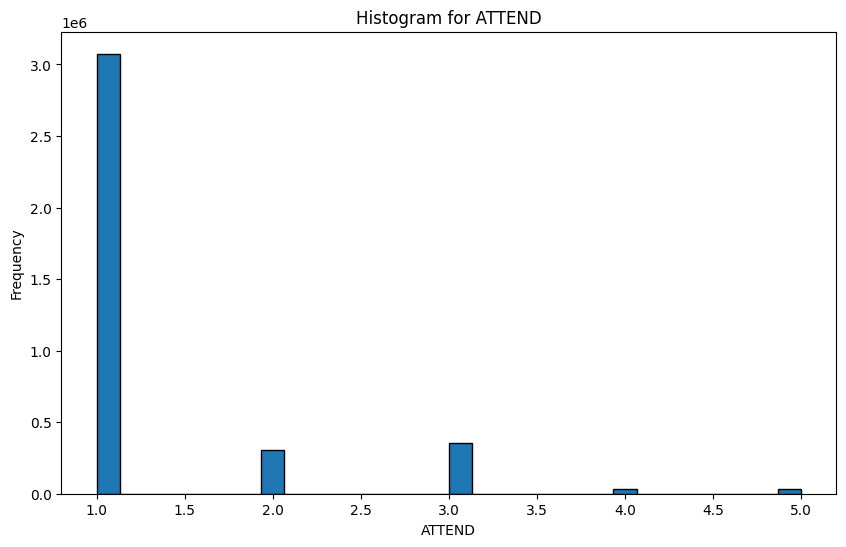

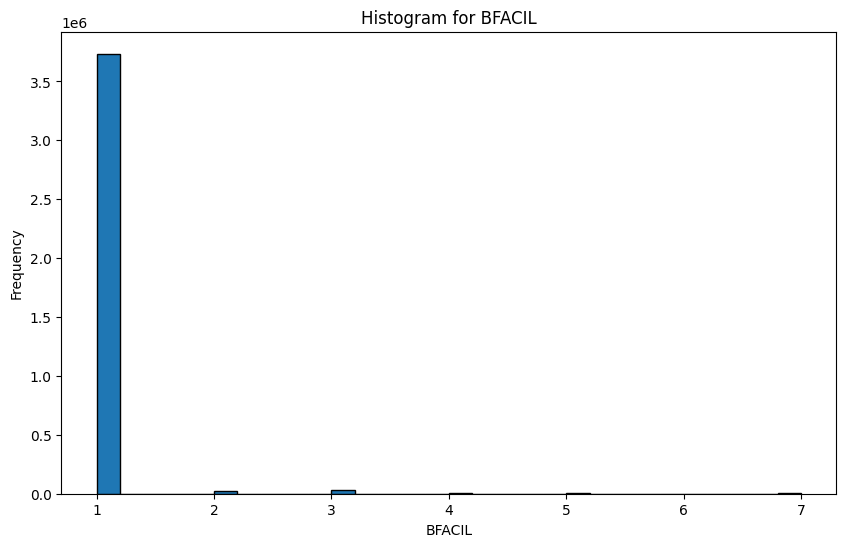

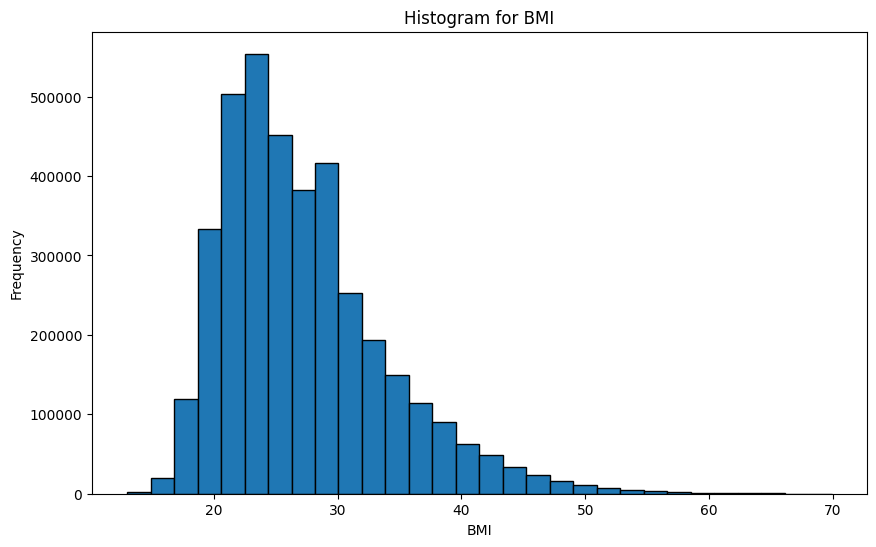

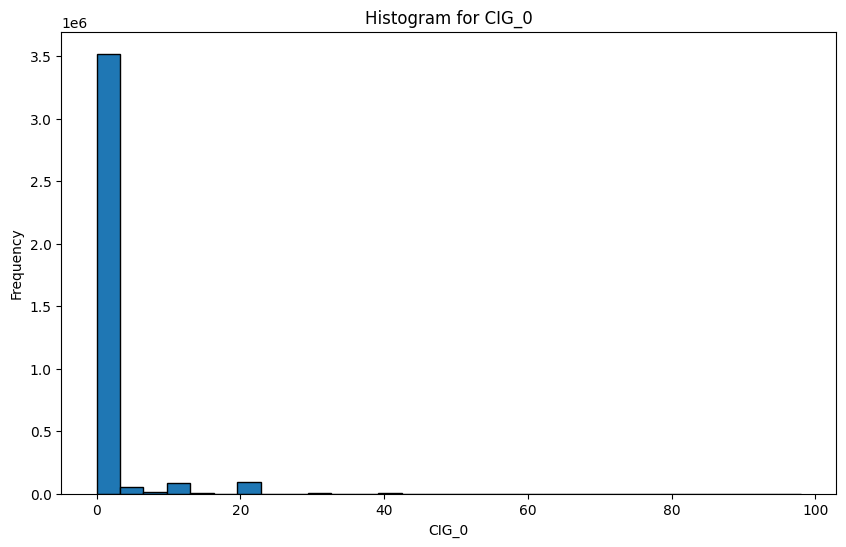

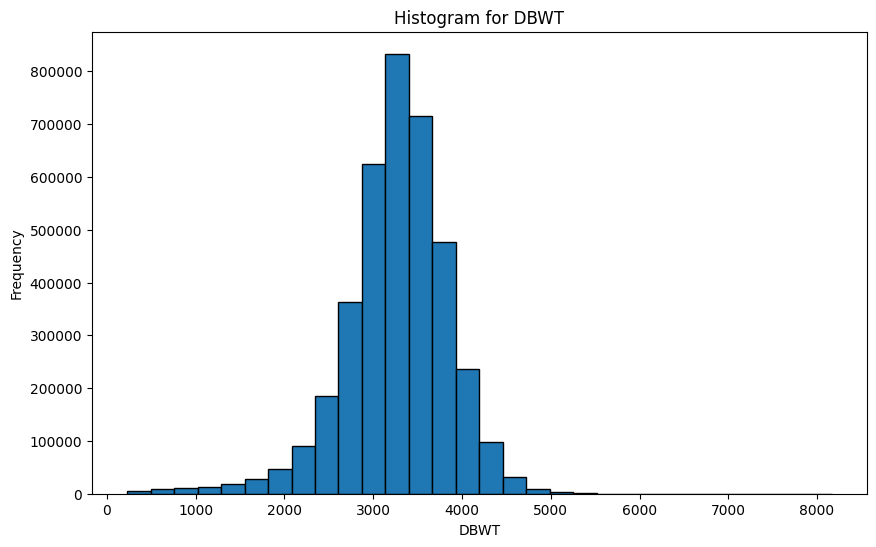

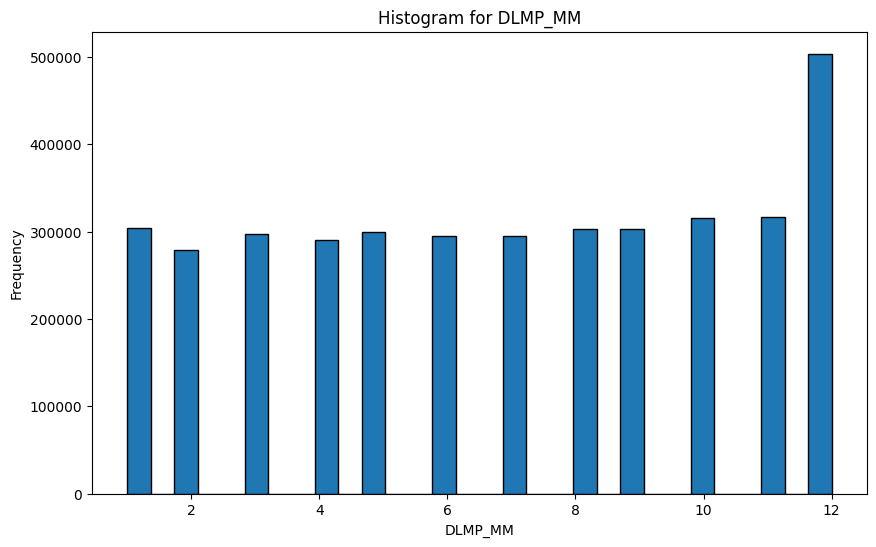

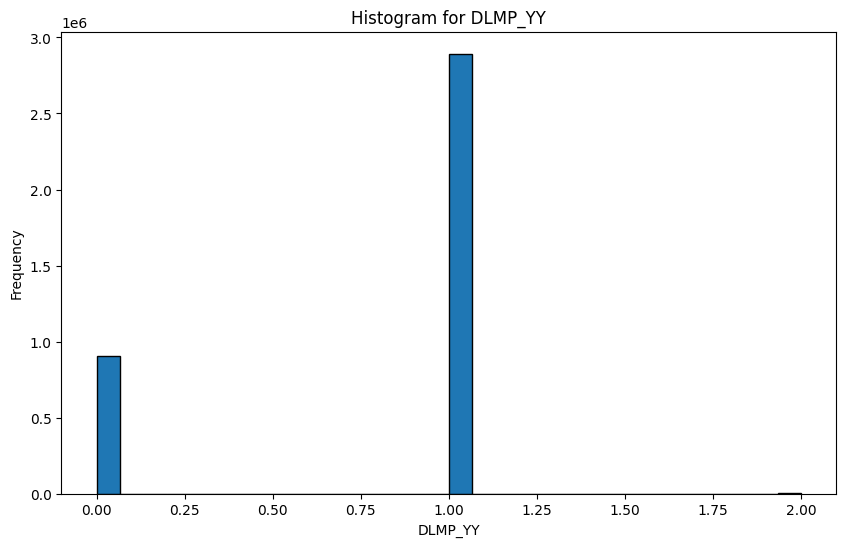

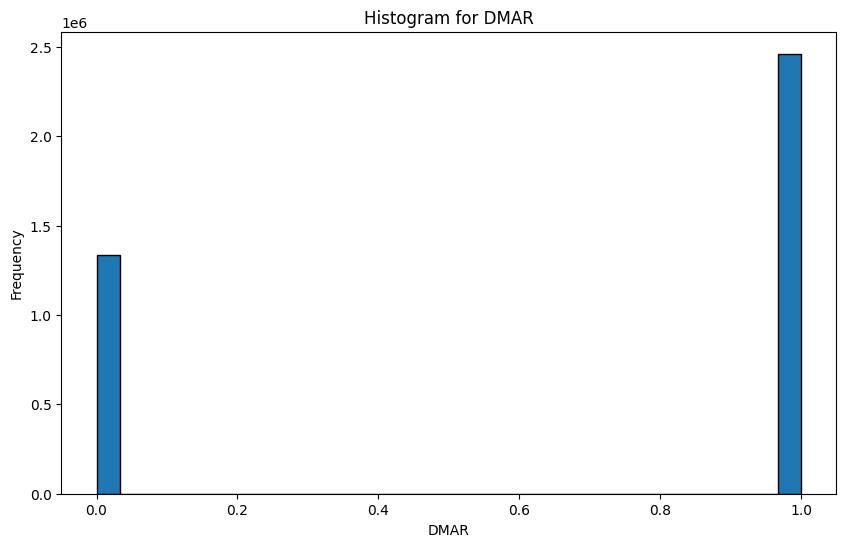

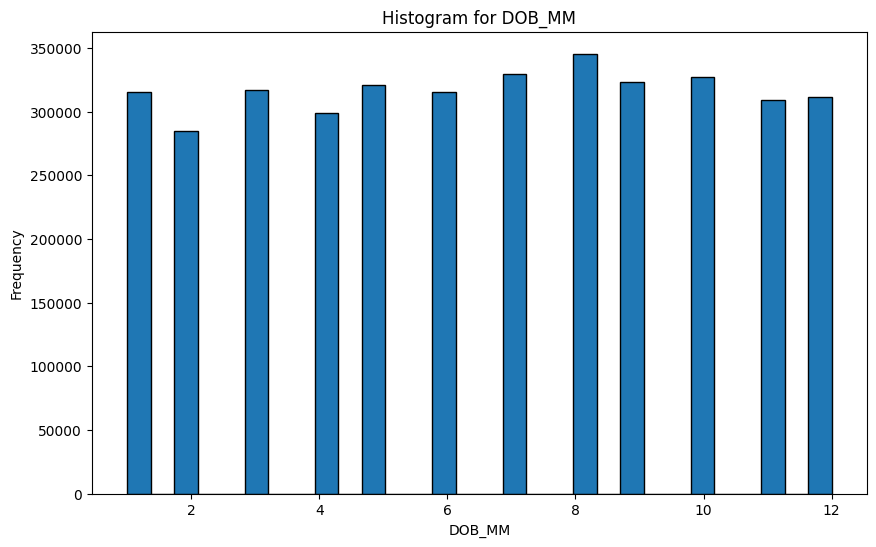

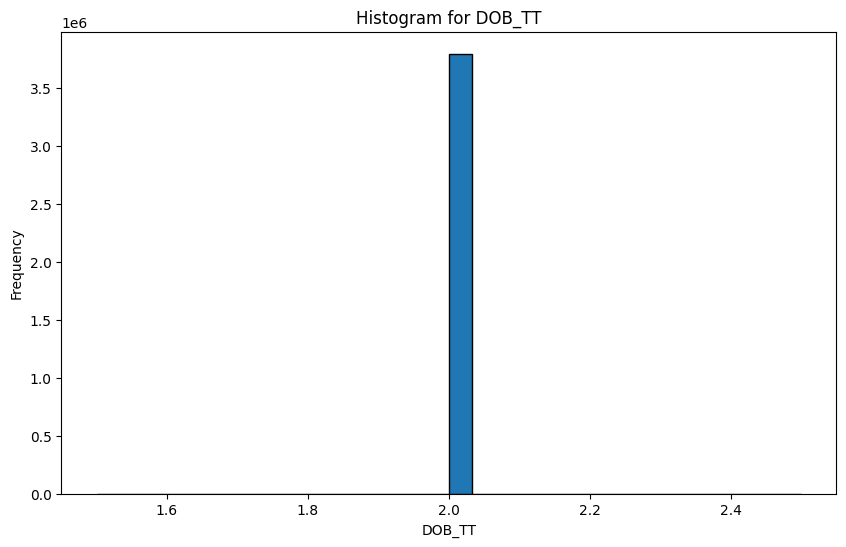

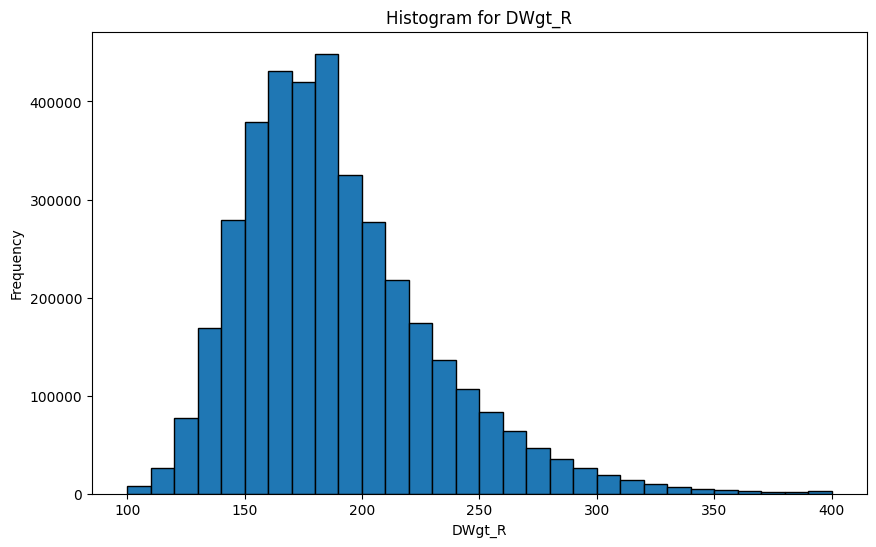

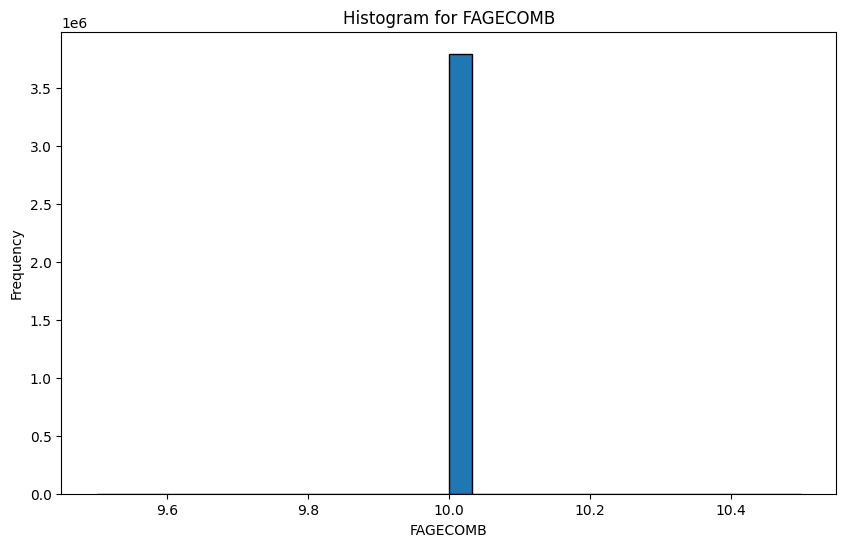

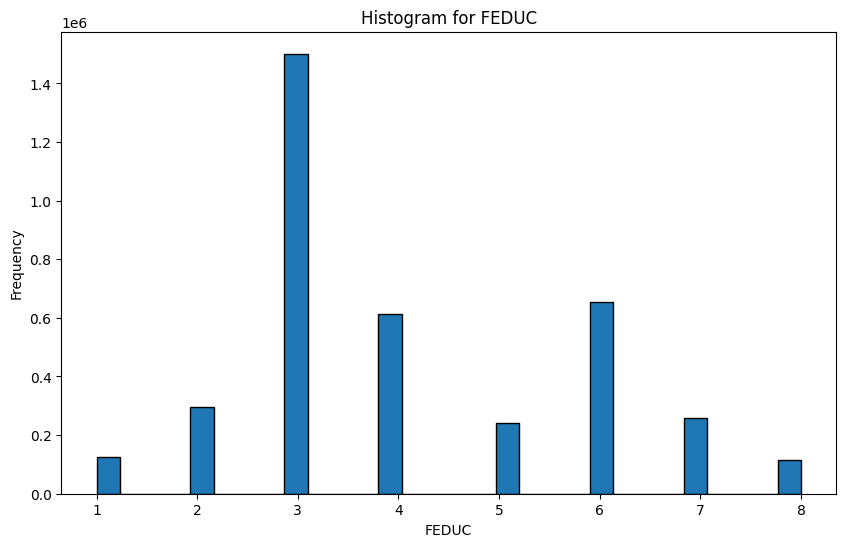

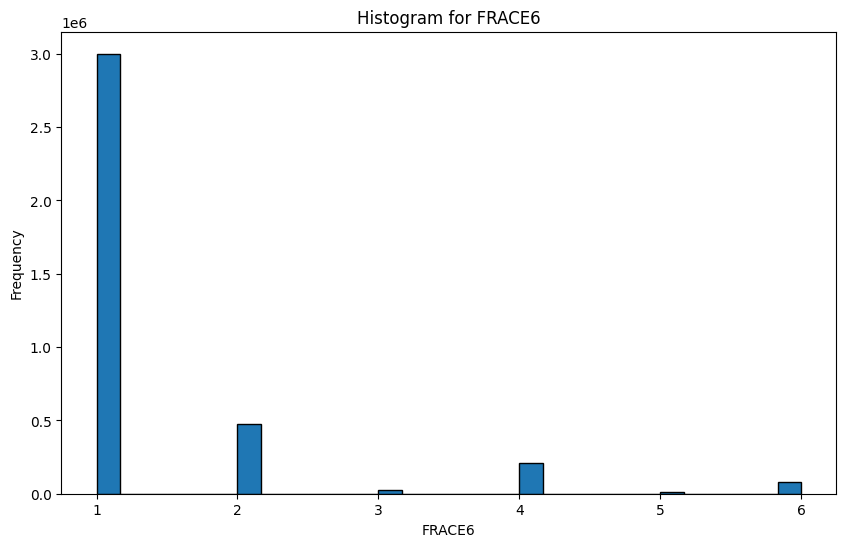

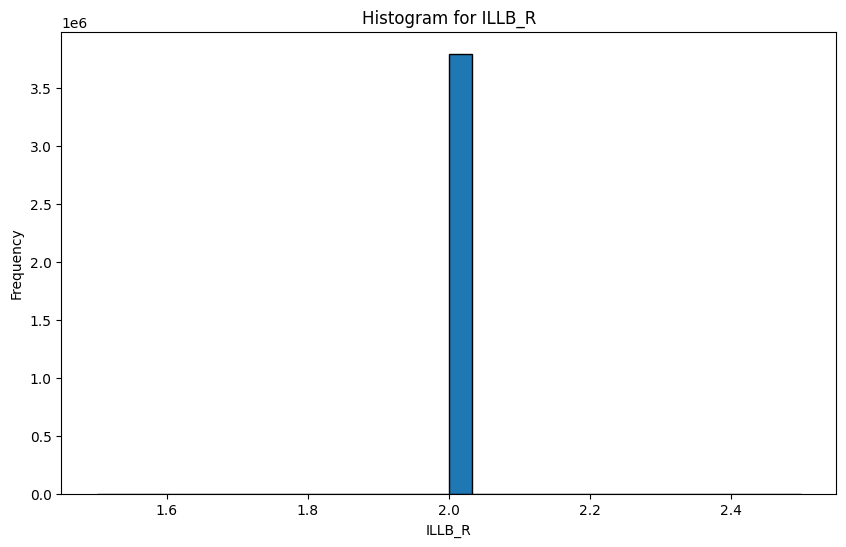

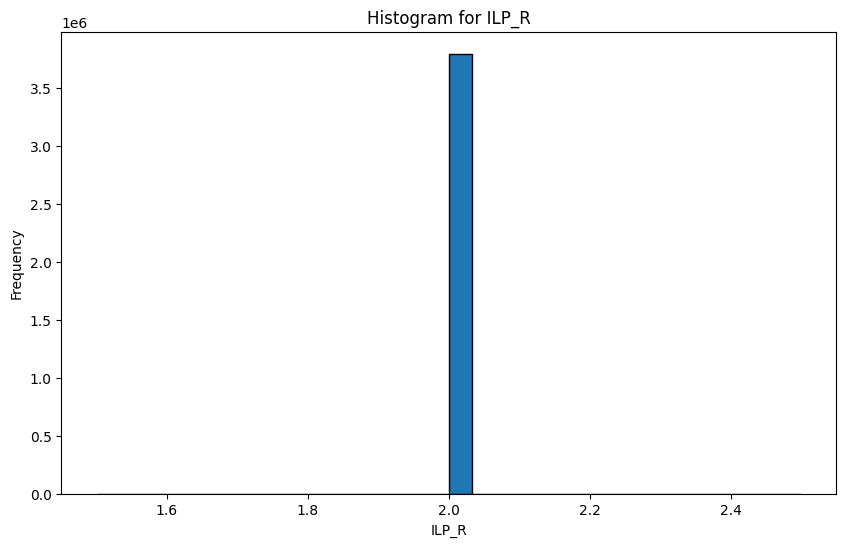

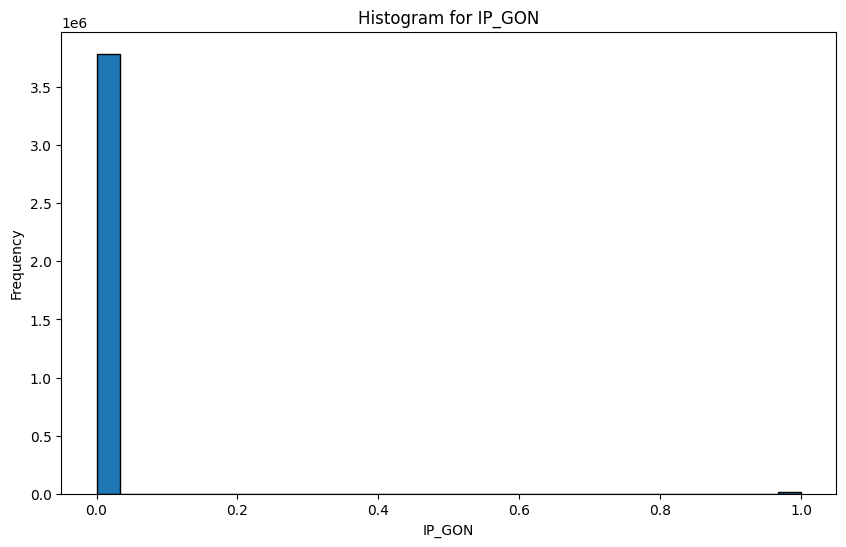

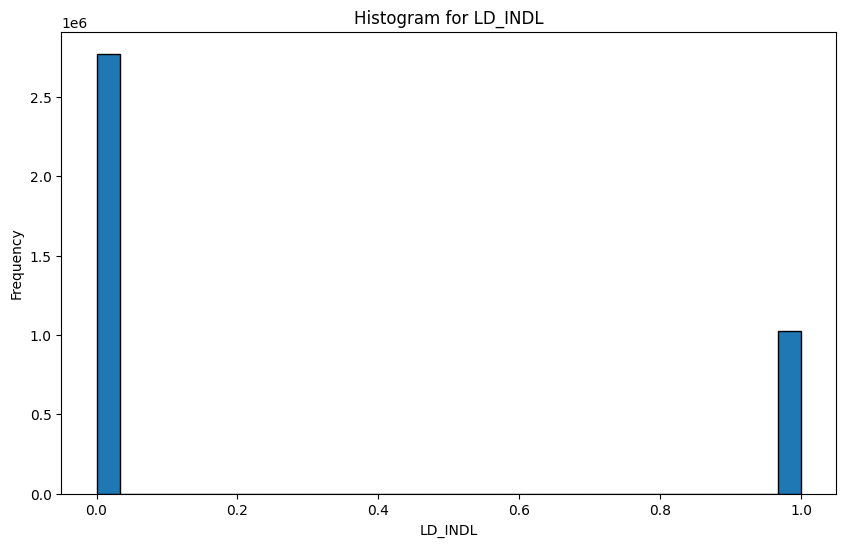

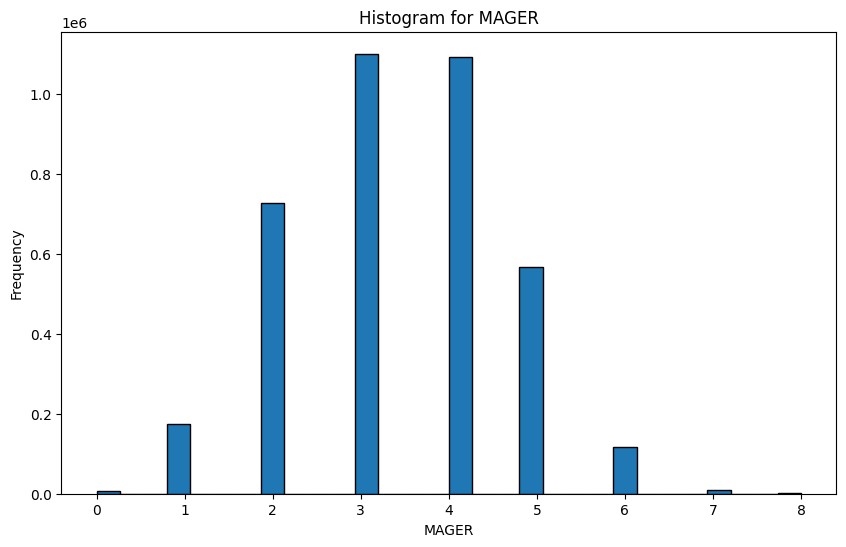

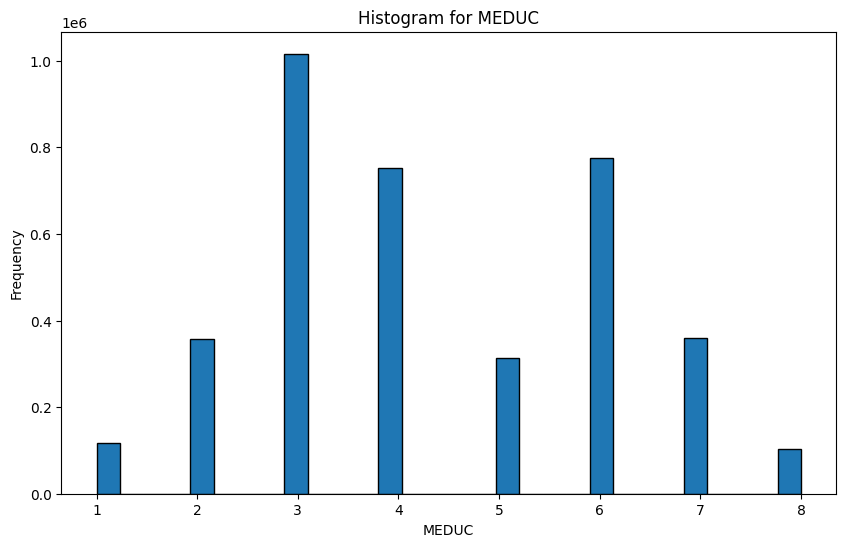

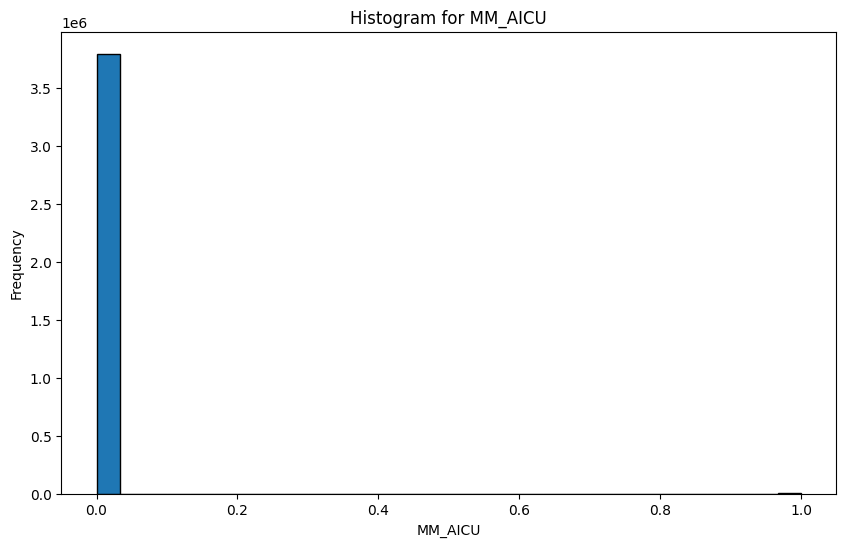

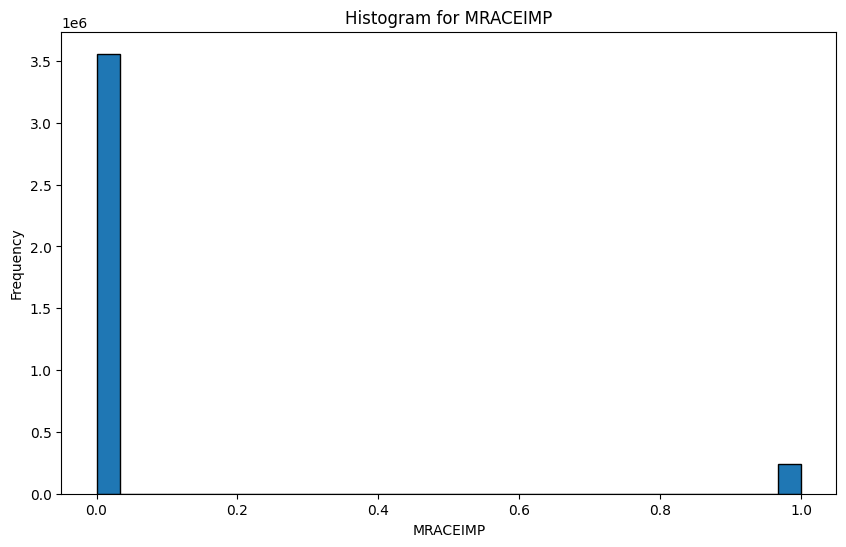

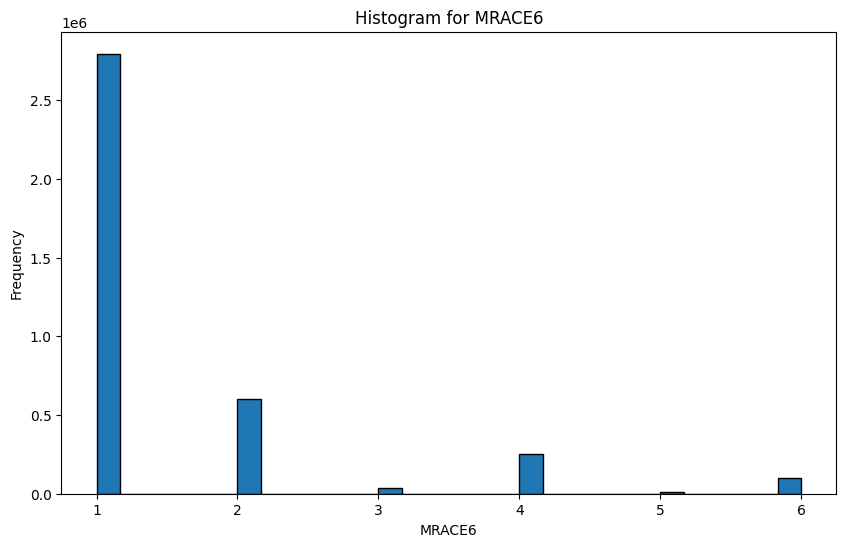

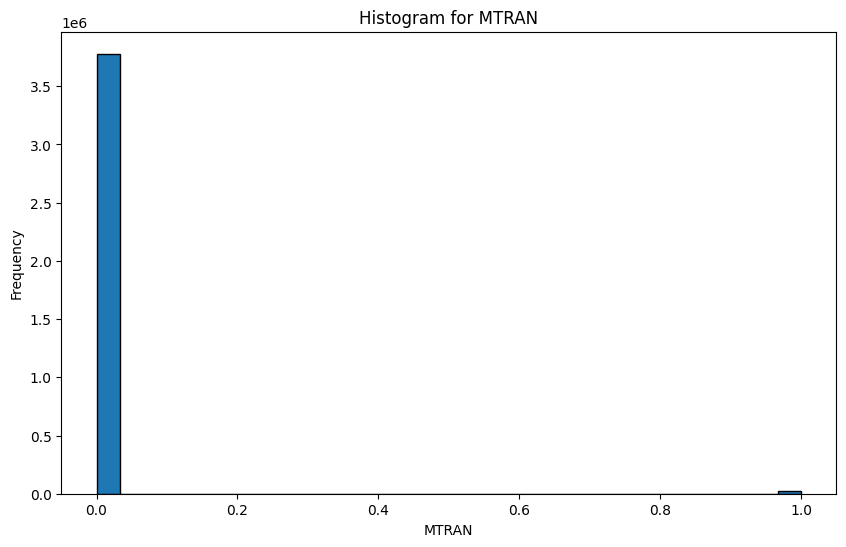

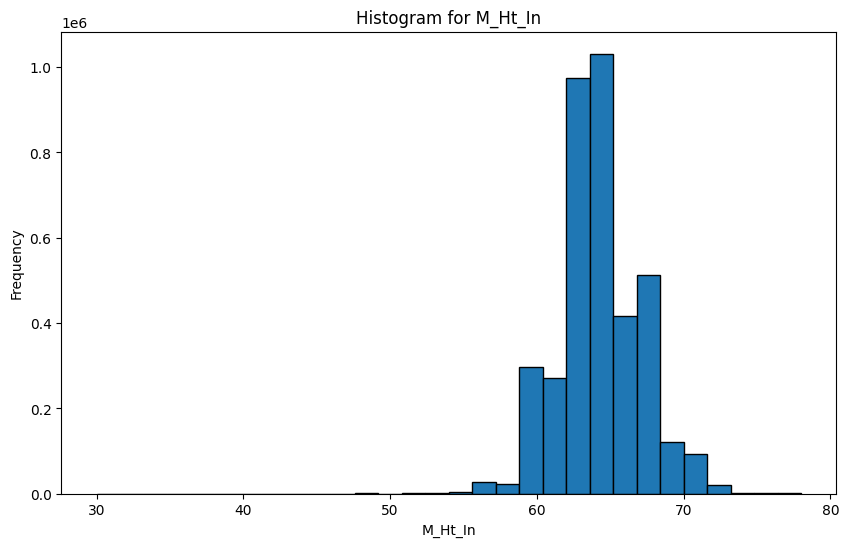

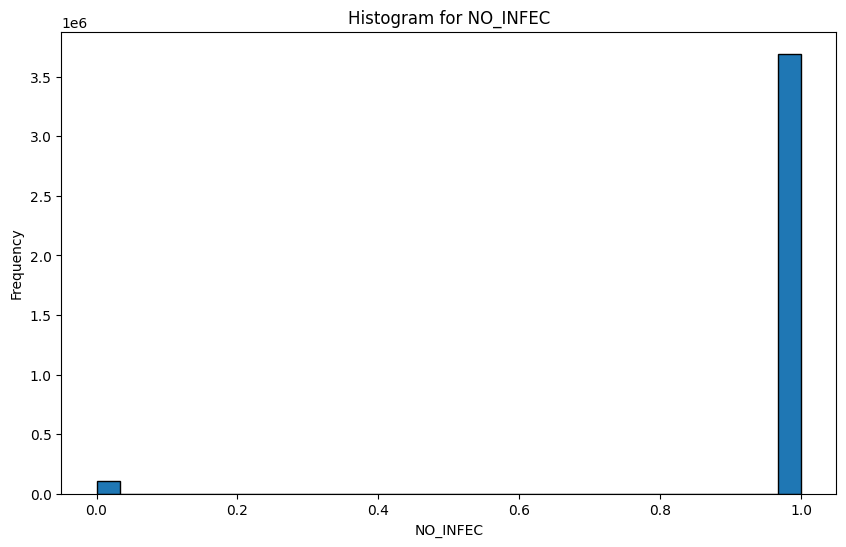

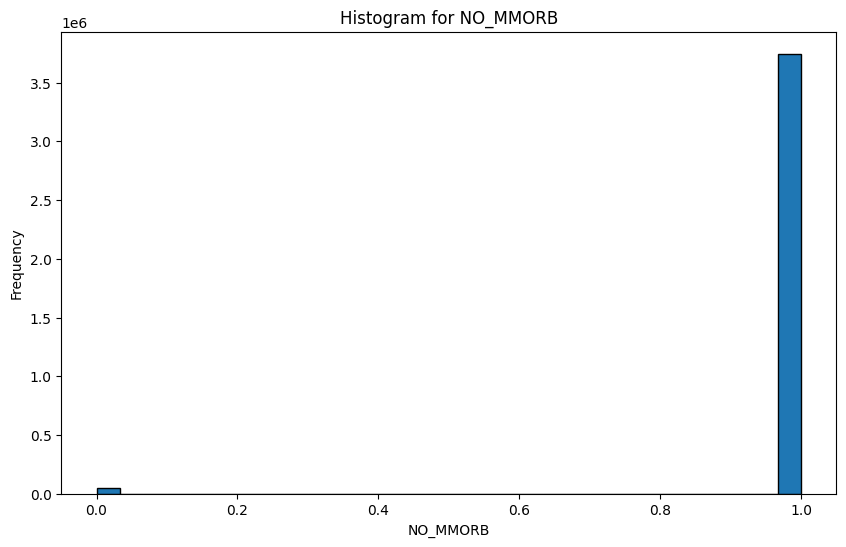

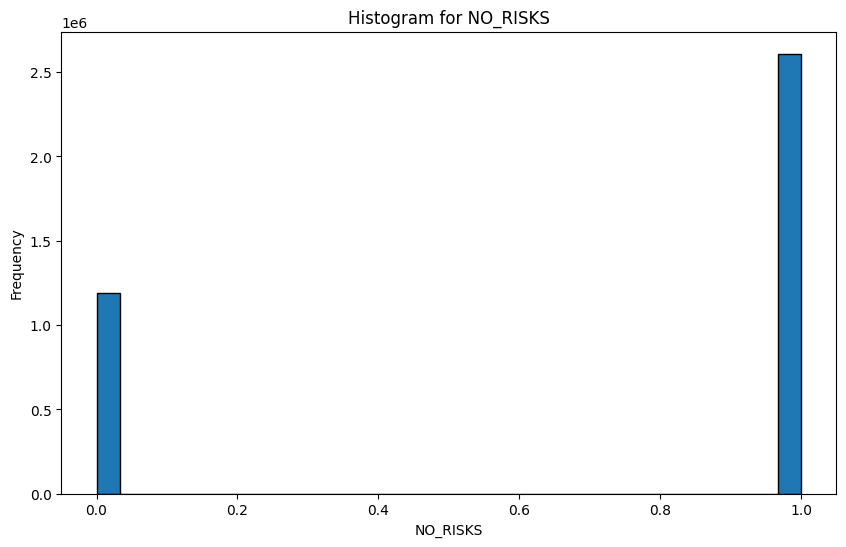

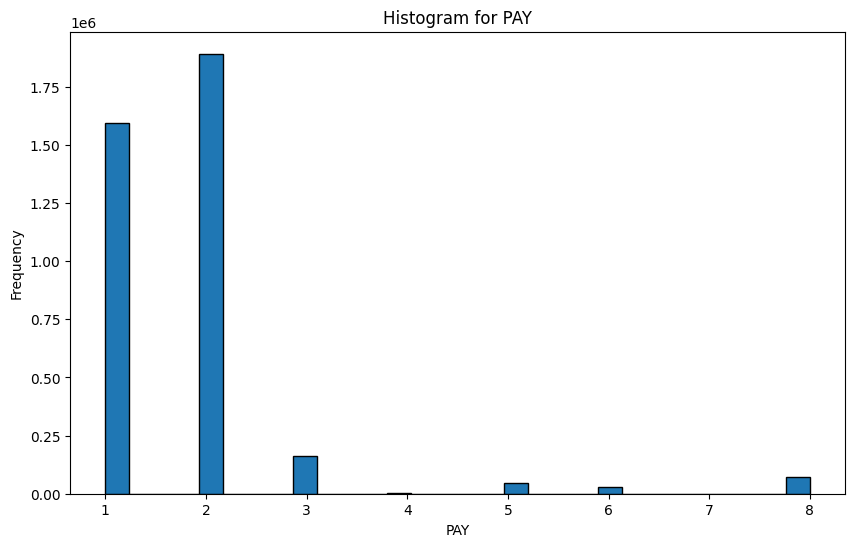

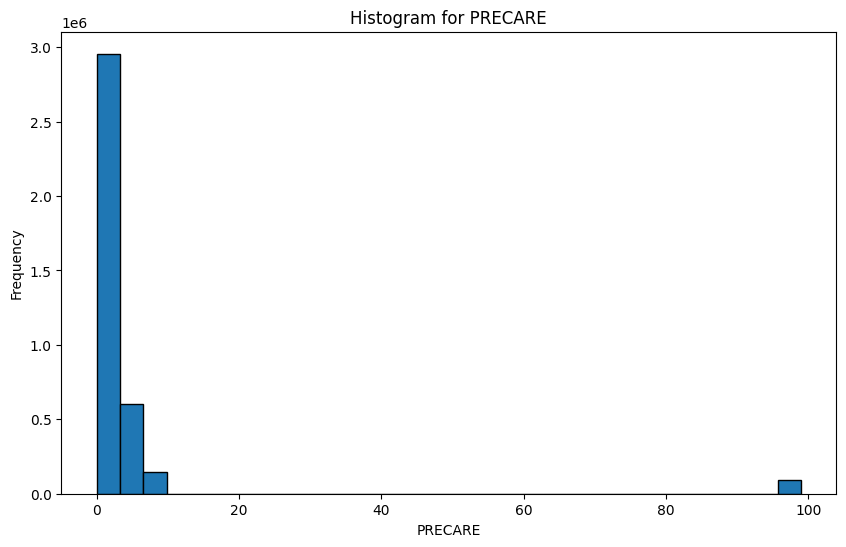

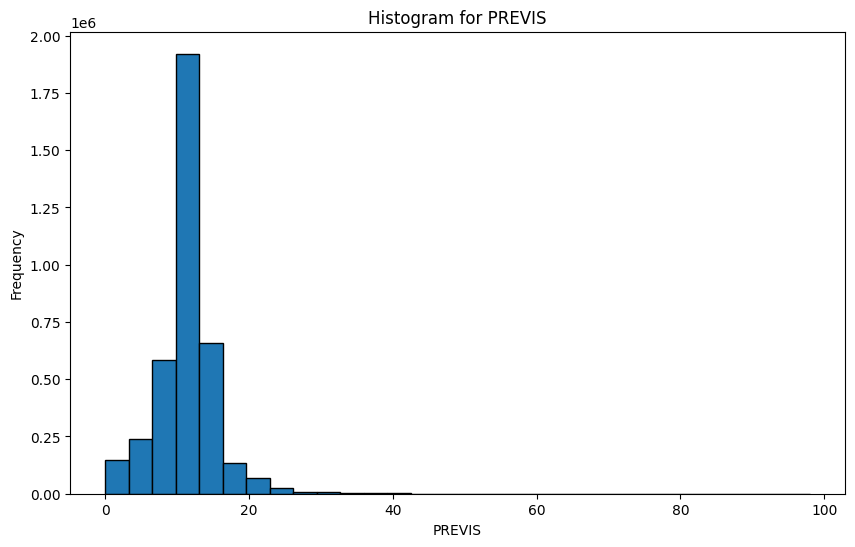

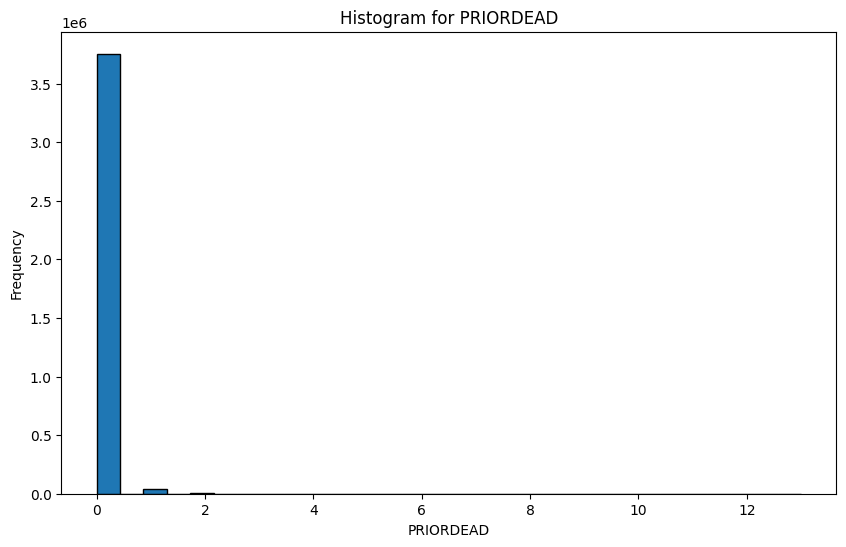

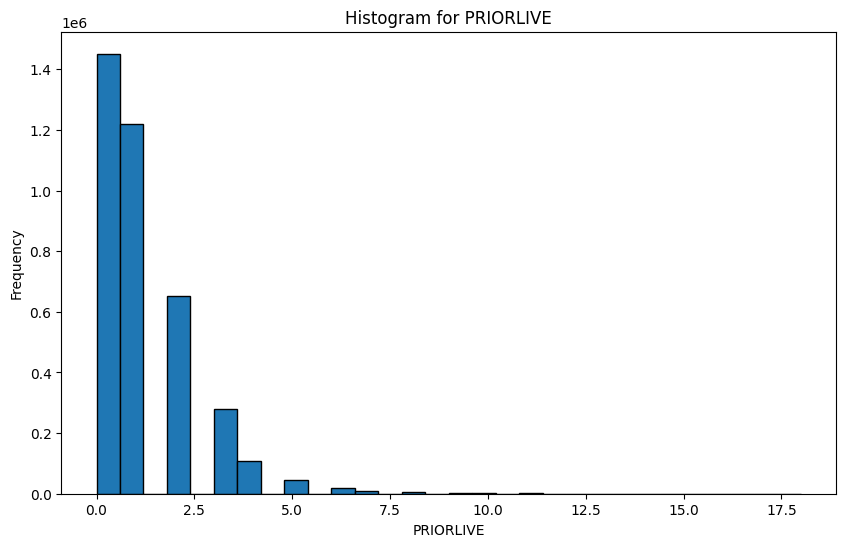

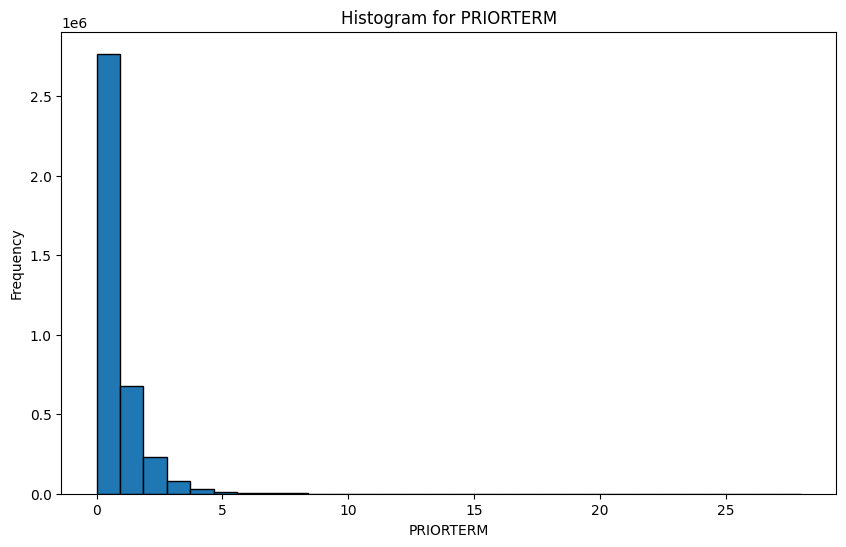

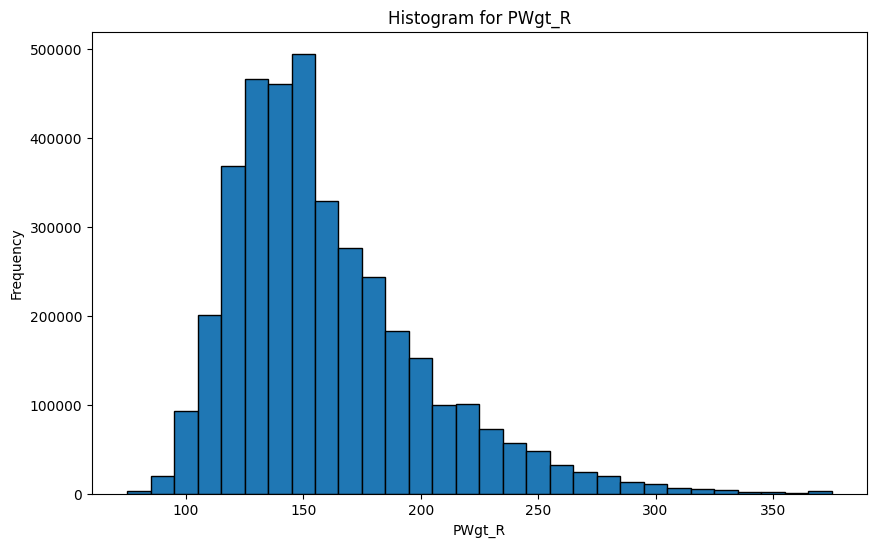

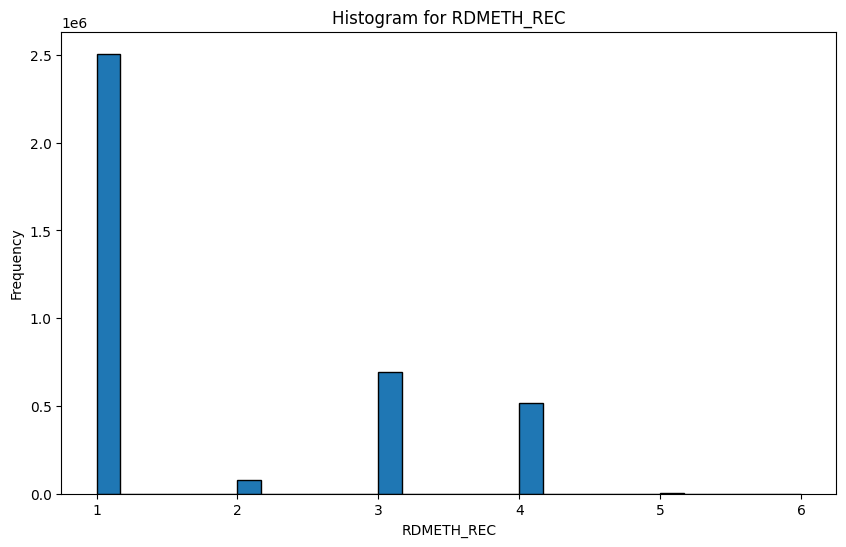

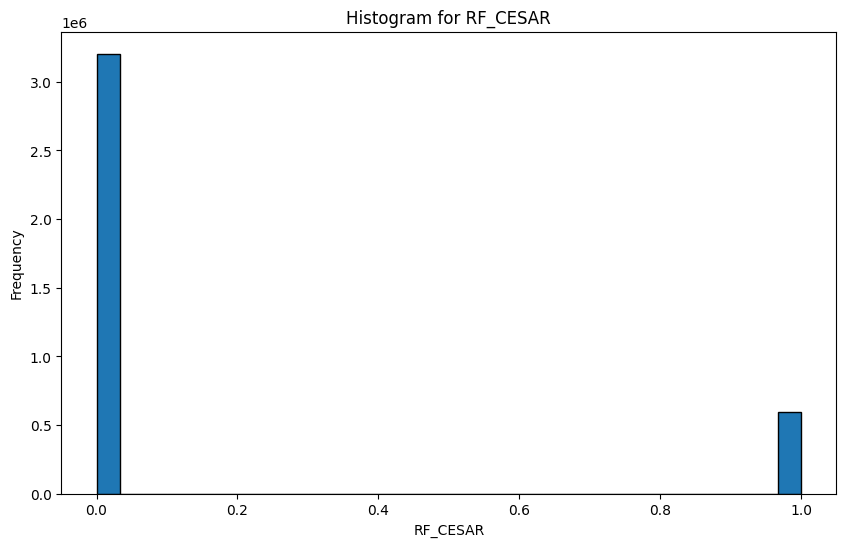

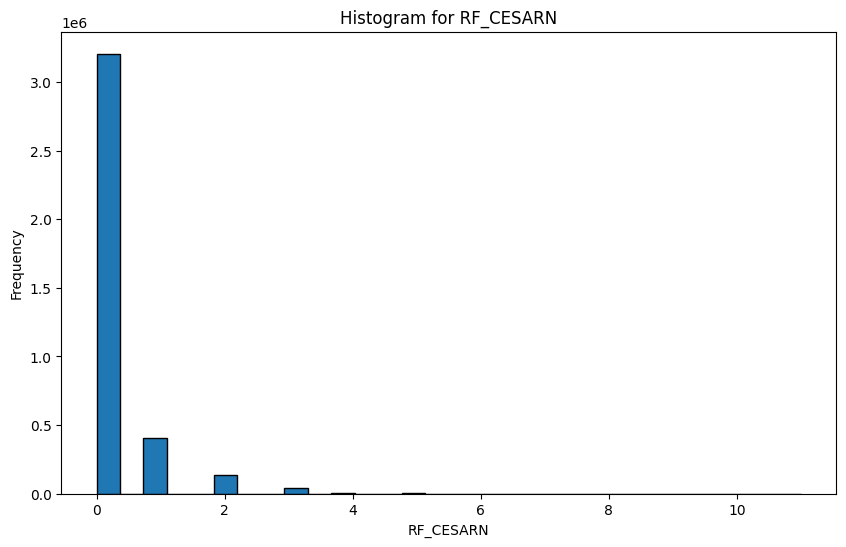

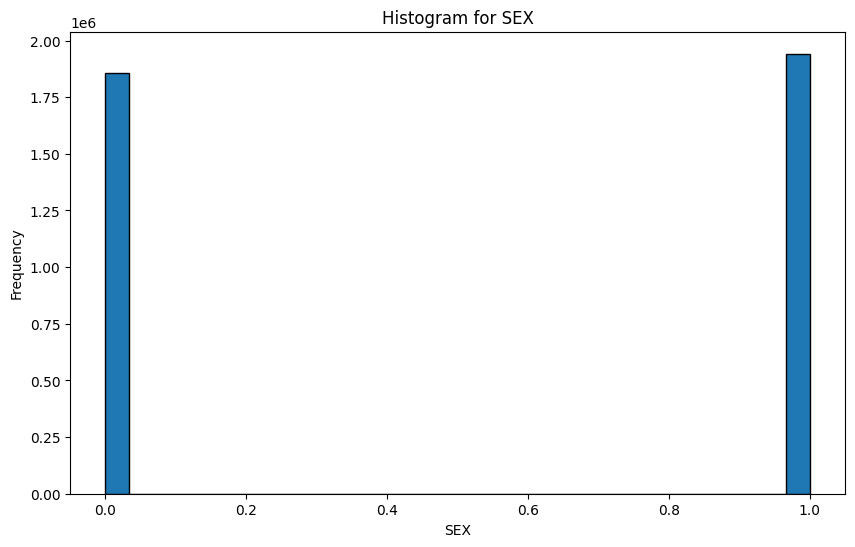

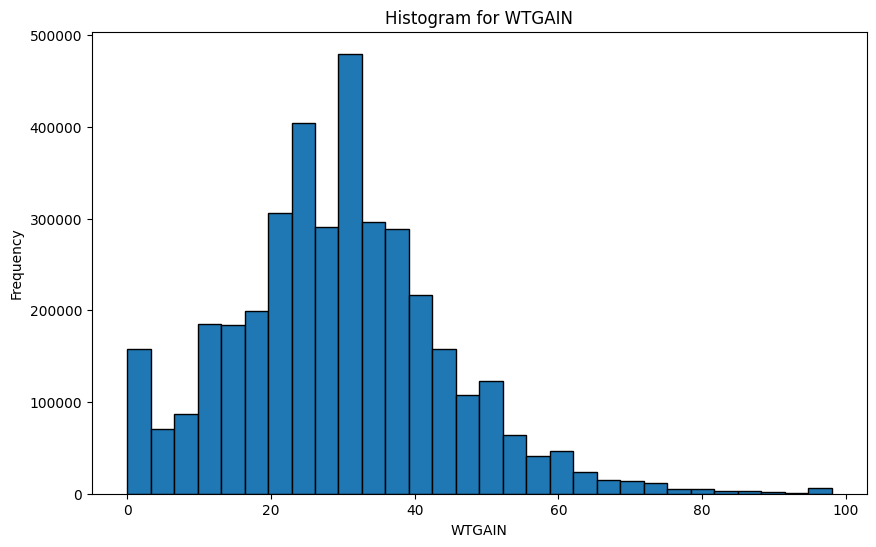

In [24]:
for column in df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='black')

    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.show()

Looking at the histograms for certain continuos variables, we can see that their distribution is skewed away from the centre. This can affect models like ours which uses gradient descent.

We will therefore be normalizing these features for more powerful predictions.

We will be importing the MinMaxScaler() and PowerTransformer() module from Sci-Kit learn.

The Yeo-Johnson transformation method is used to get rid of any skewness in the features as much as possible.
The MinMaxScaler scales the values to a range between 0 and 1.

In [25]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler

In [26]:
pt = PowerTransformer(method = 'yeo-johnson', standardize = False)
scaler = MinMaxScaler()


columns_to_transform = ['BMI', 'DWgt_R', 'PWgt_R', 'M_Ht_In', 'PREVIS', 'WTGAIN']
df[columns_to_transform] = pt.fit_transform(df[columns_to_transform])
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

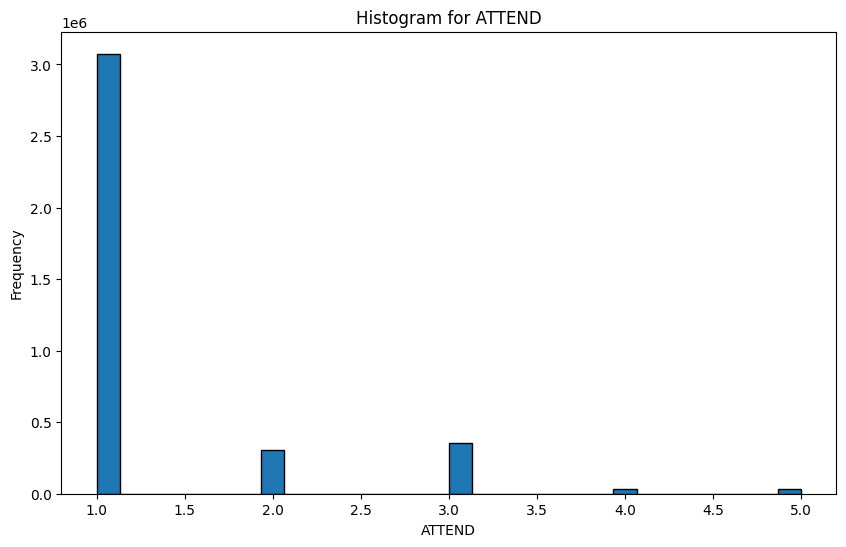

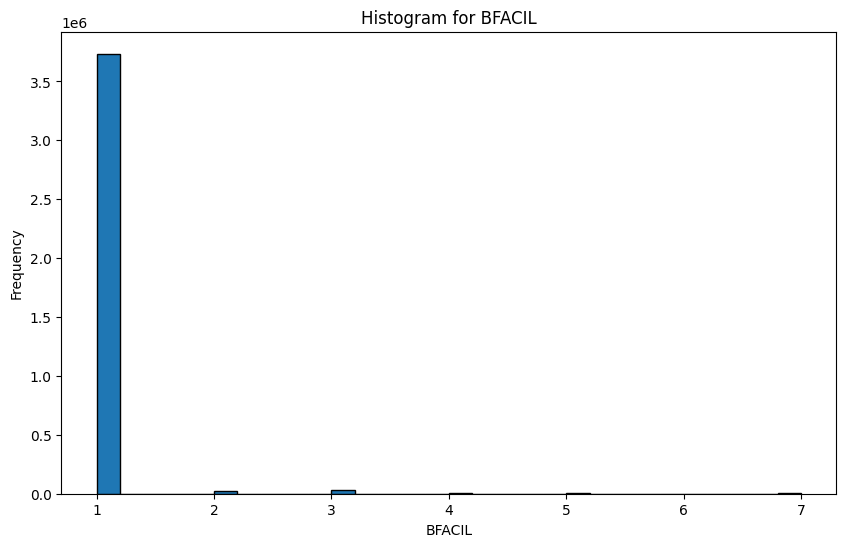

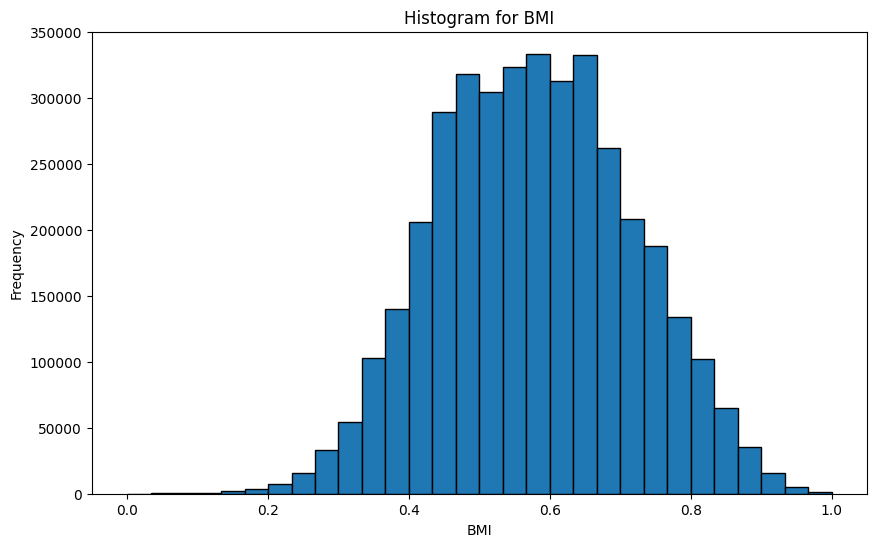

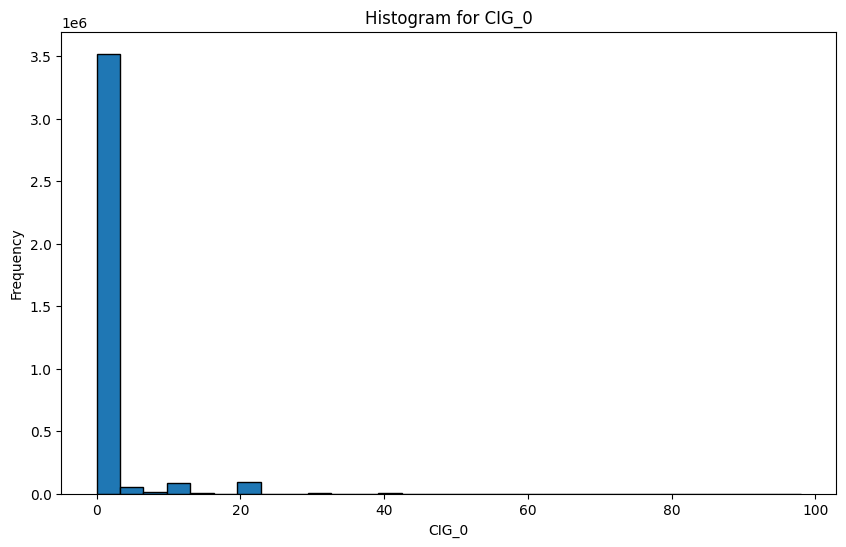

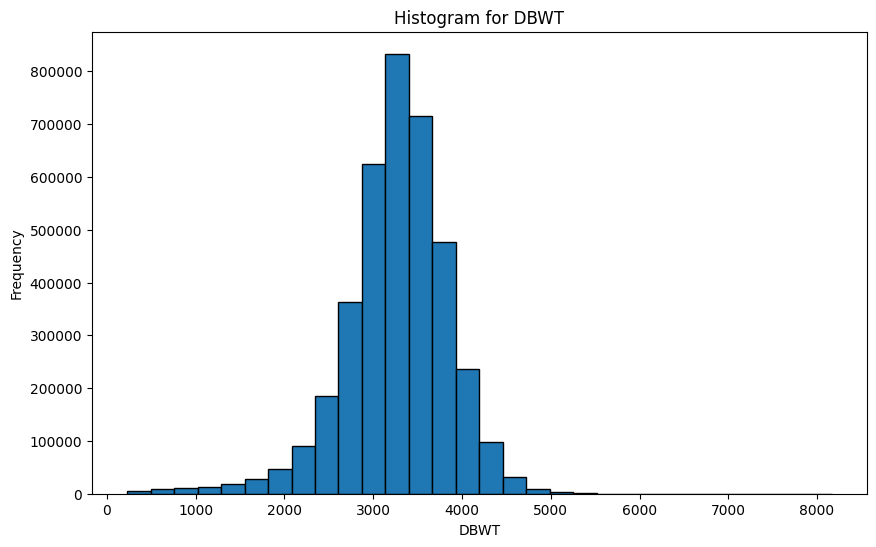

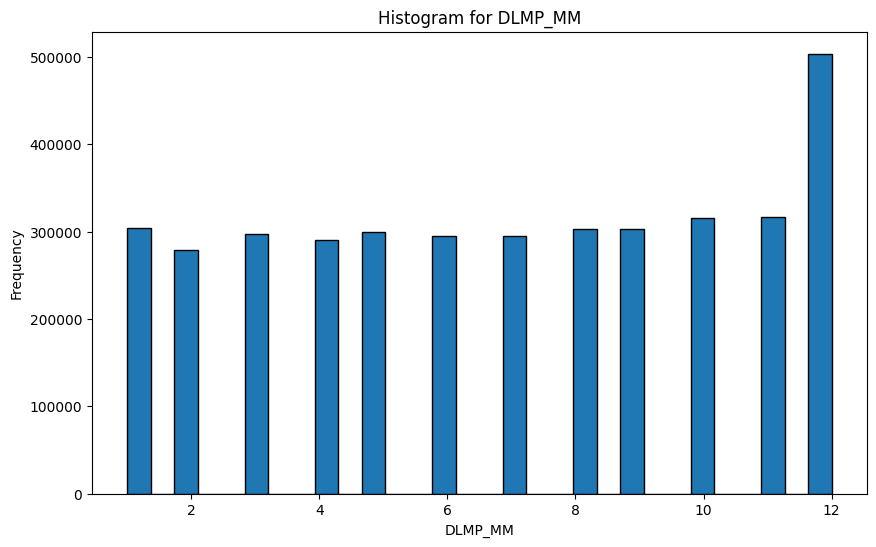

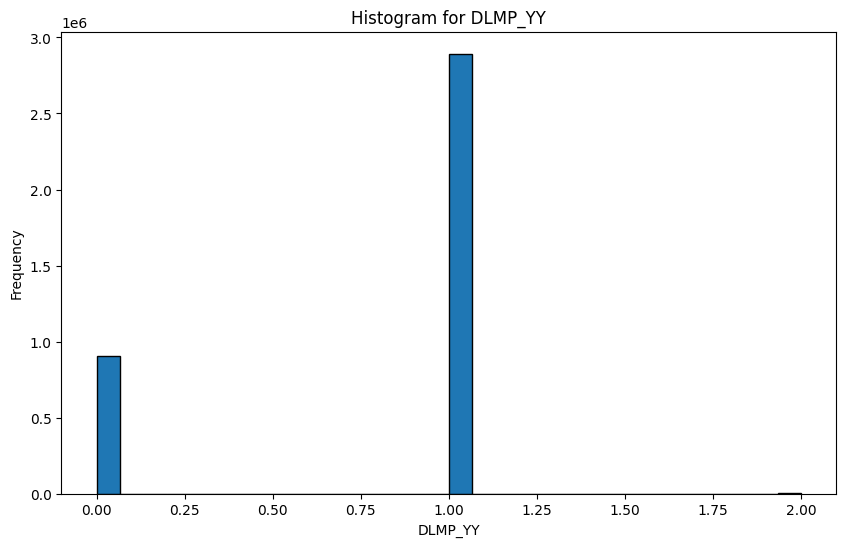

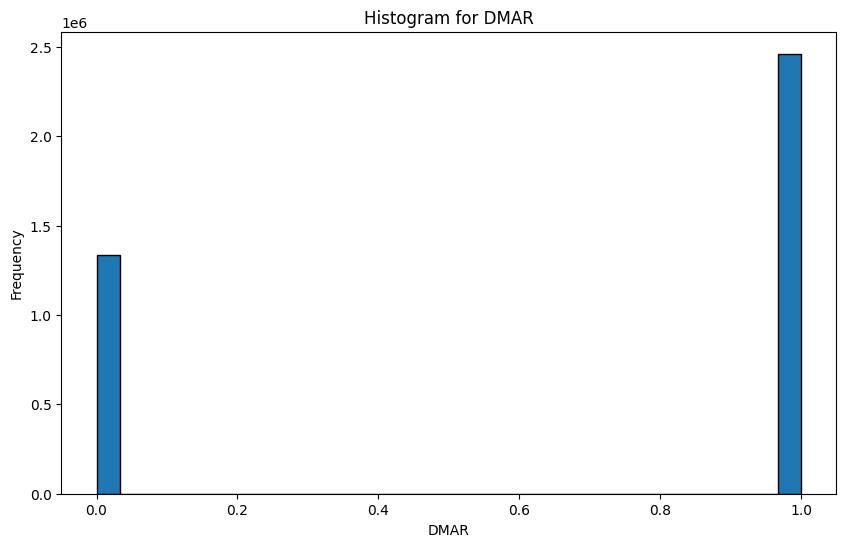

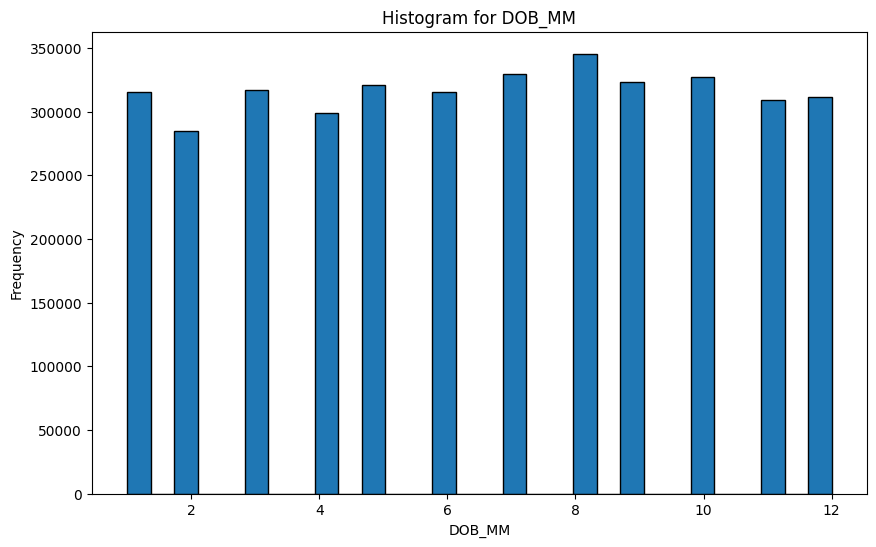

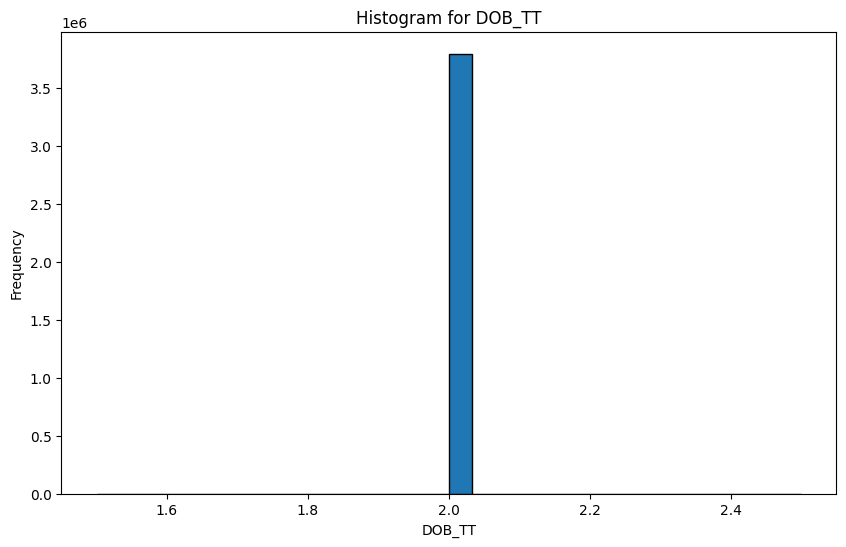

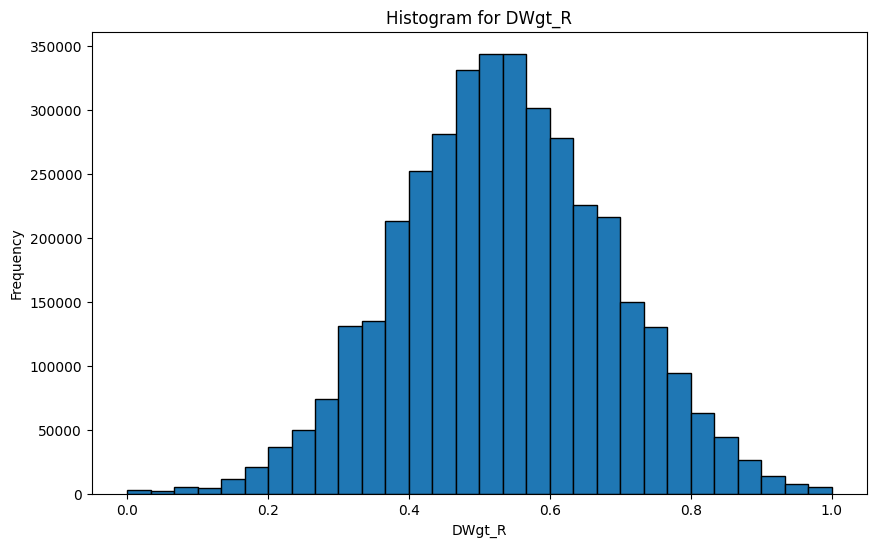

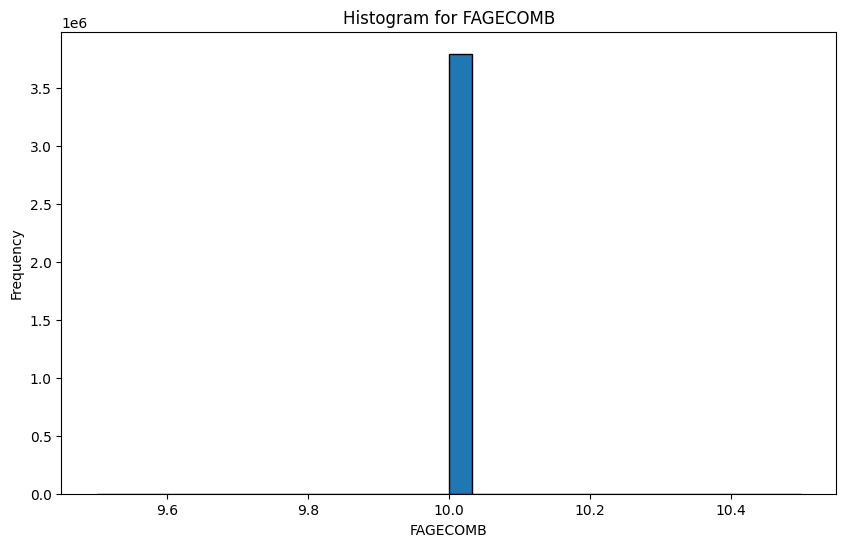

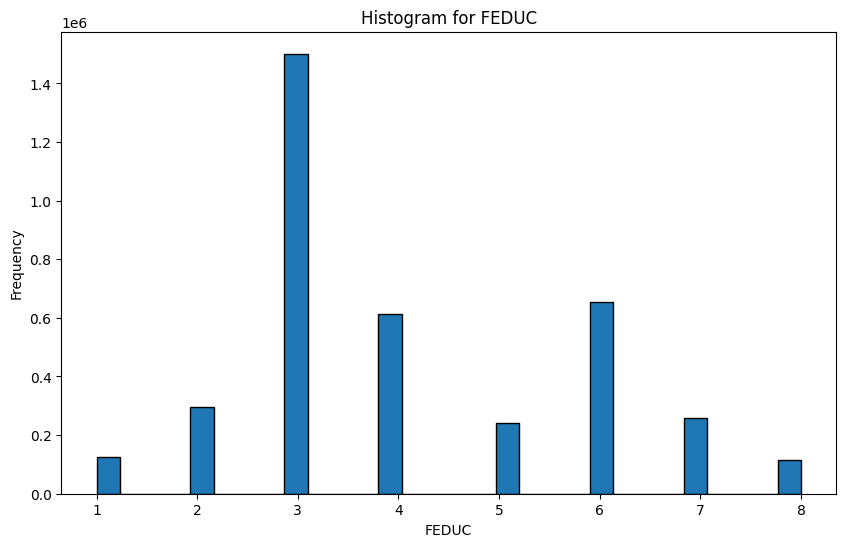

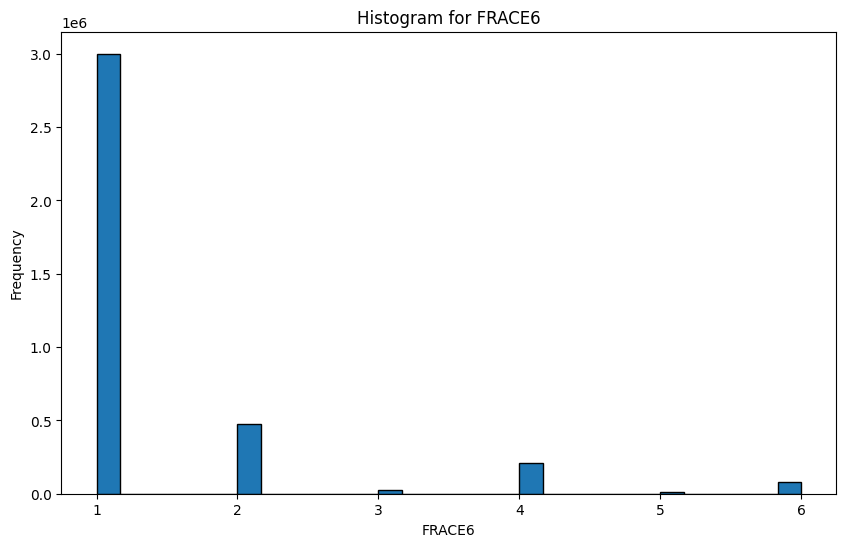

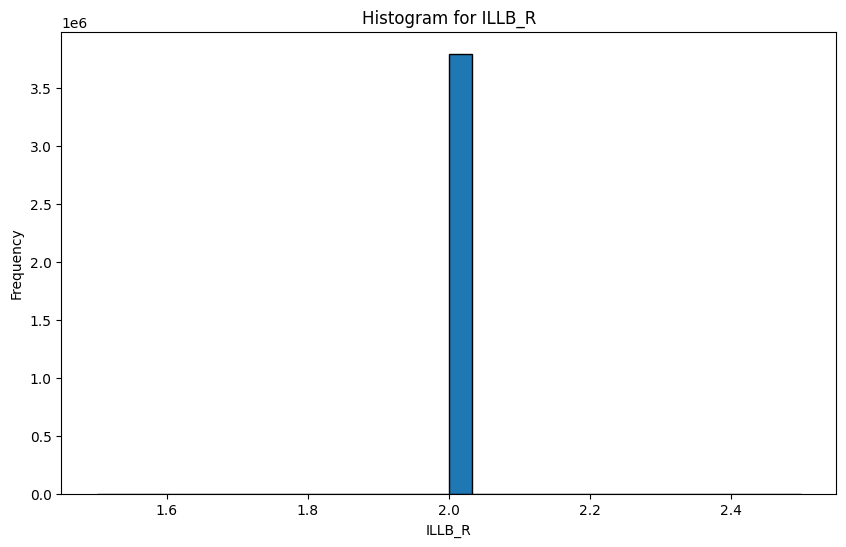

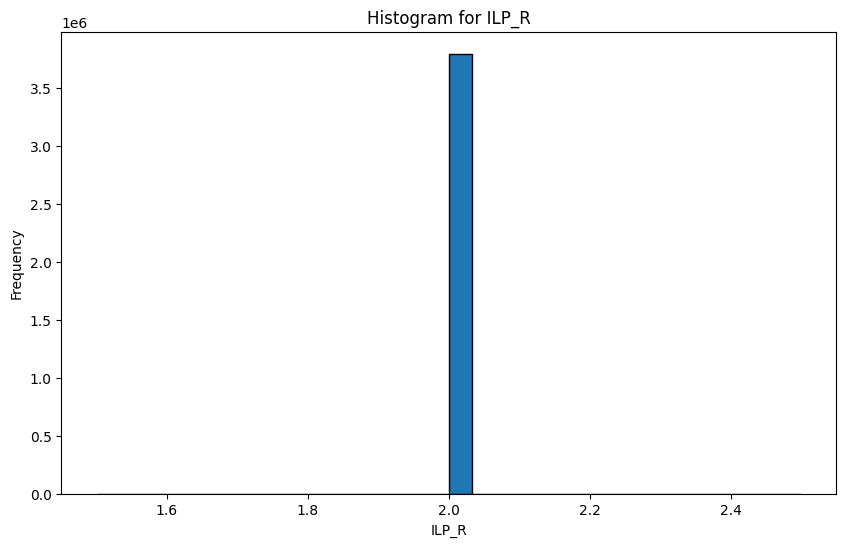

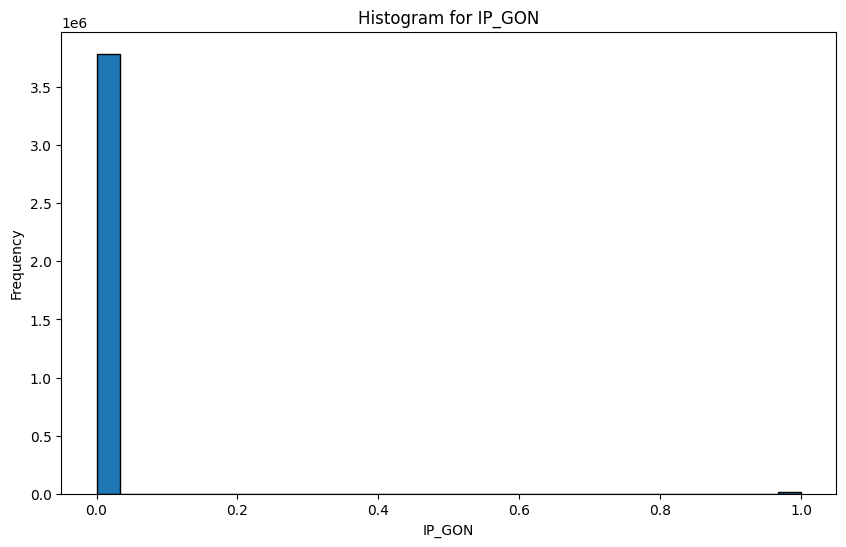

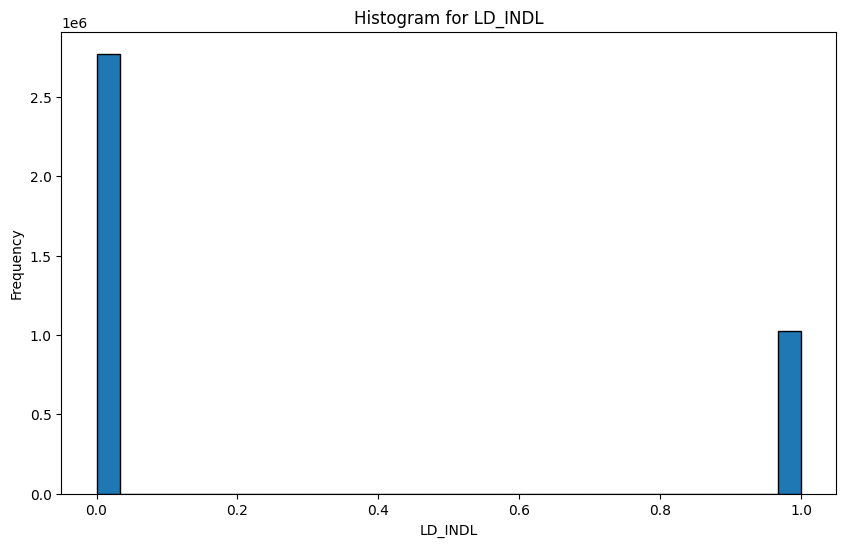

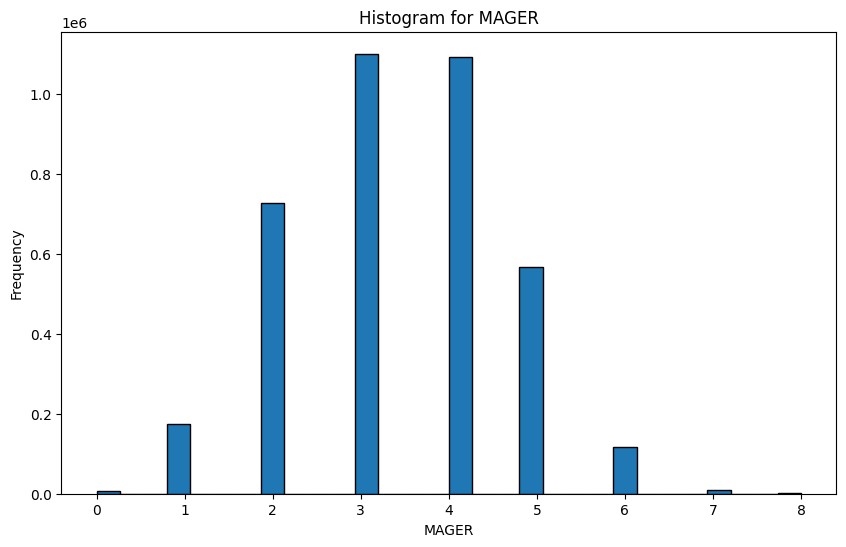

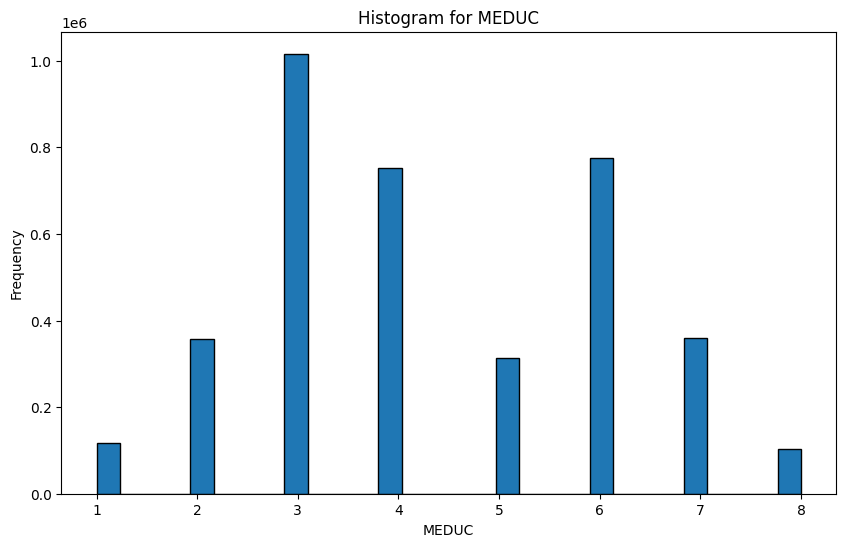

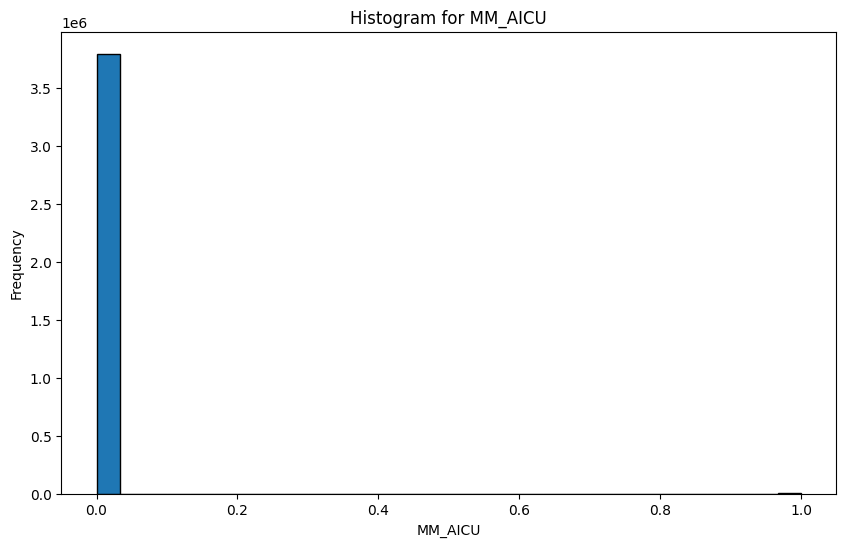

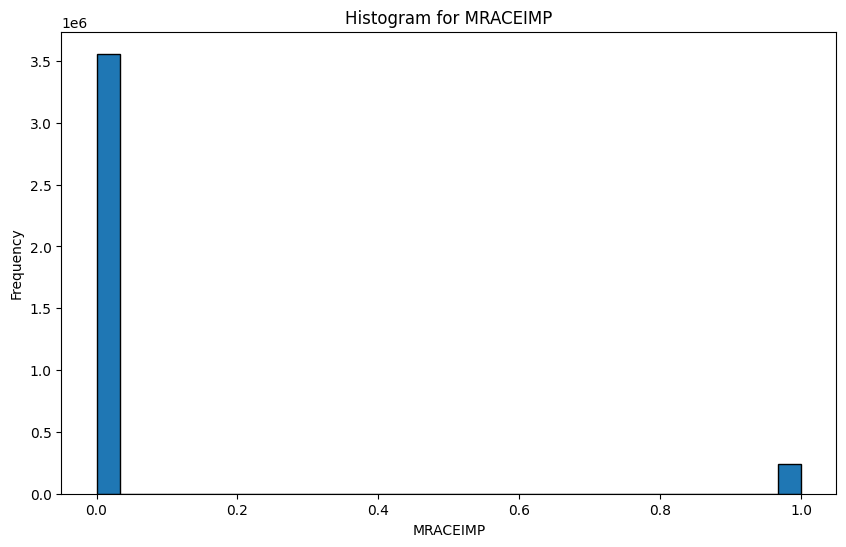

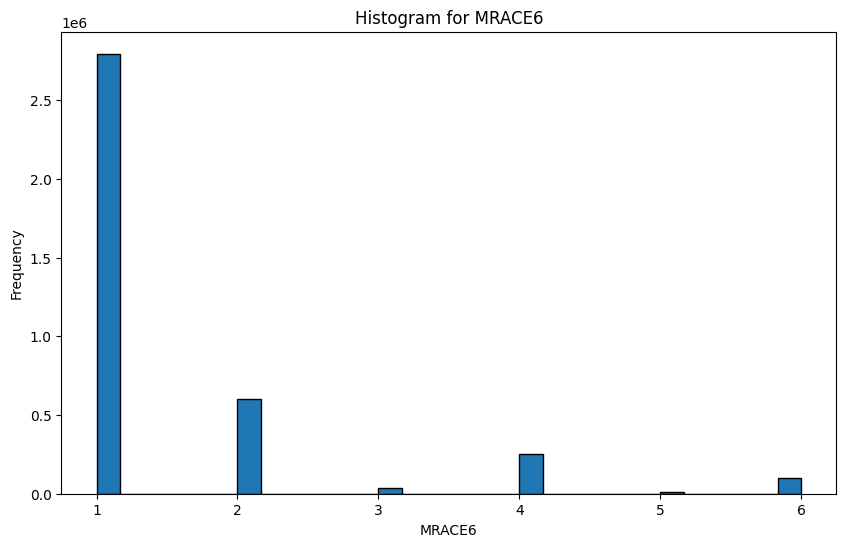

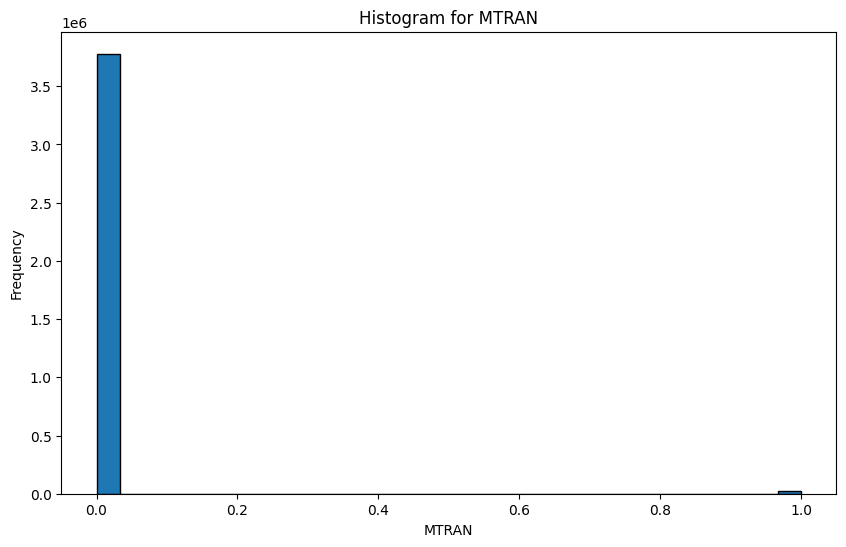

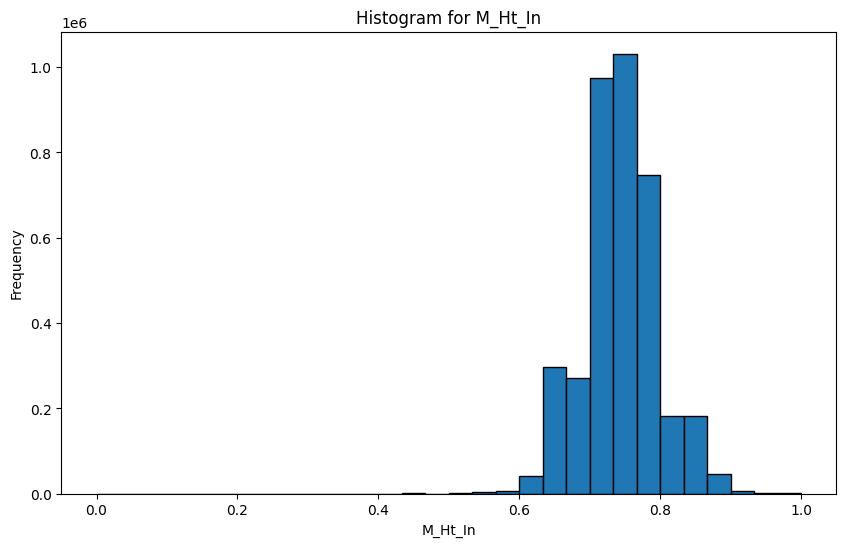

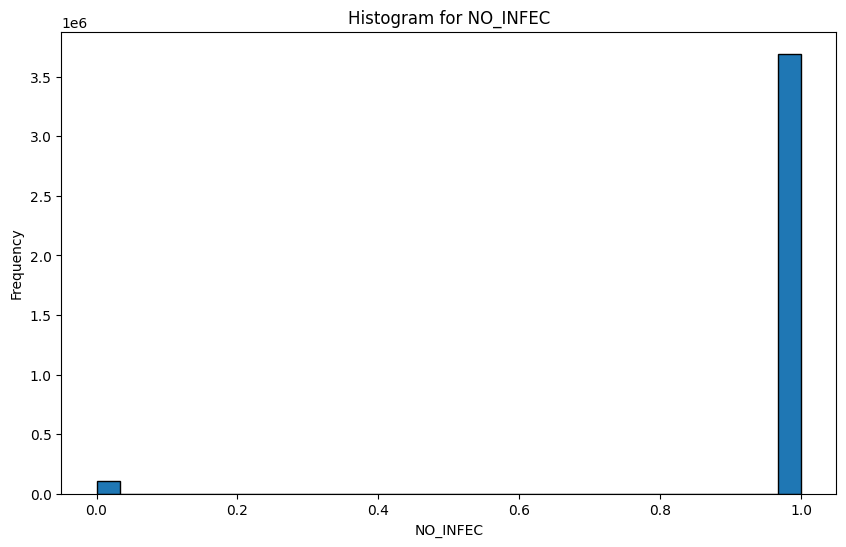

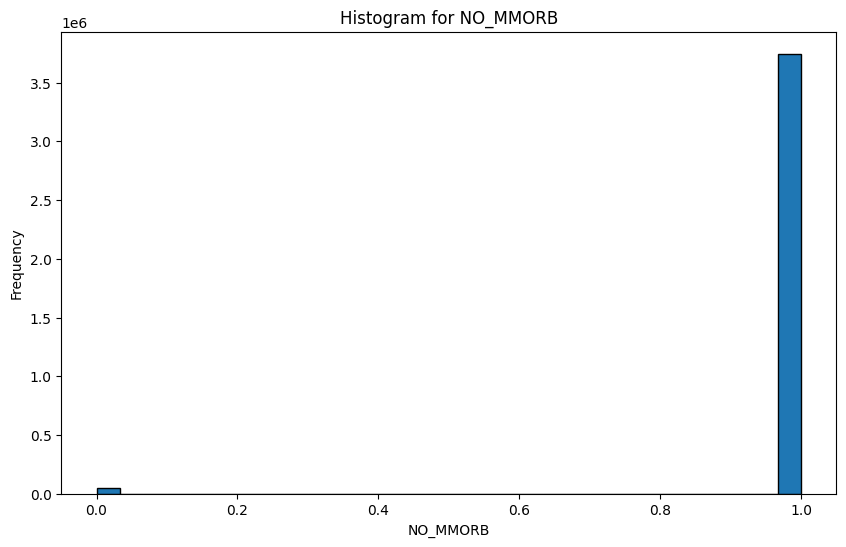

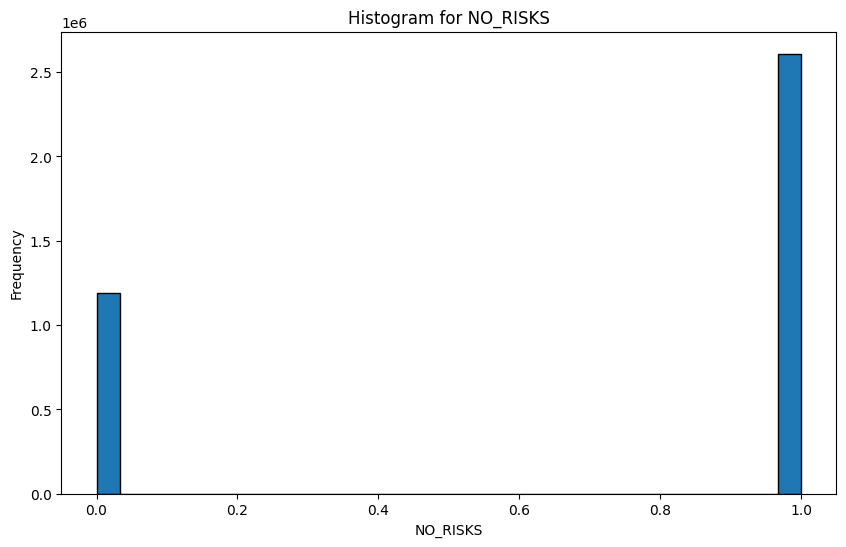

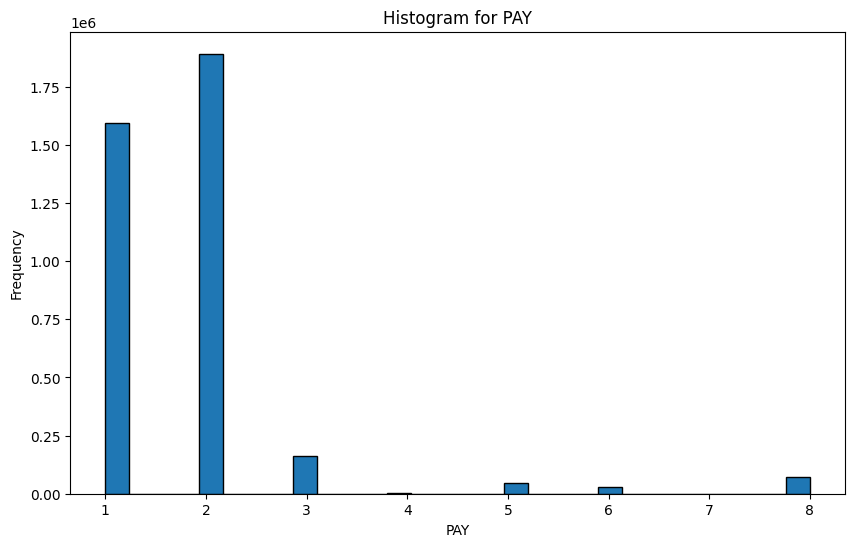

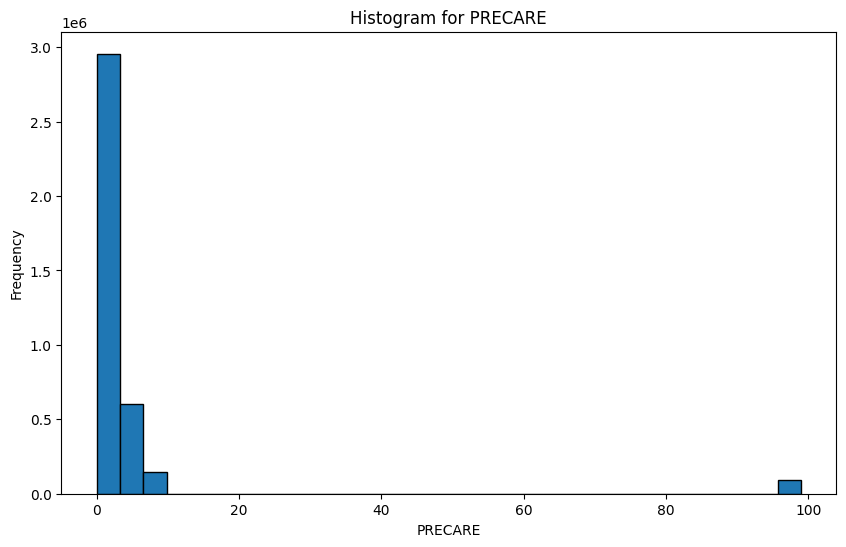

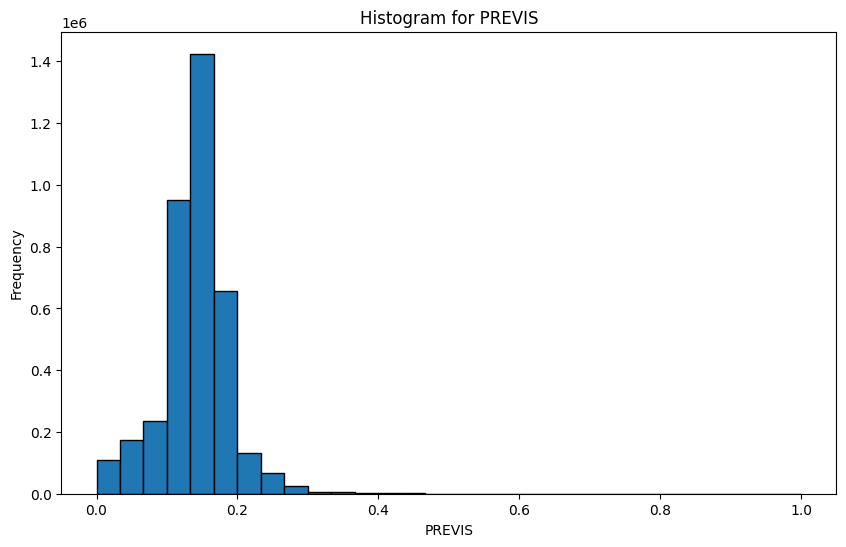

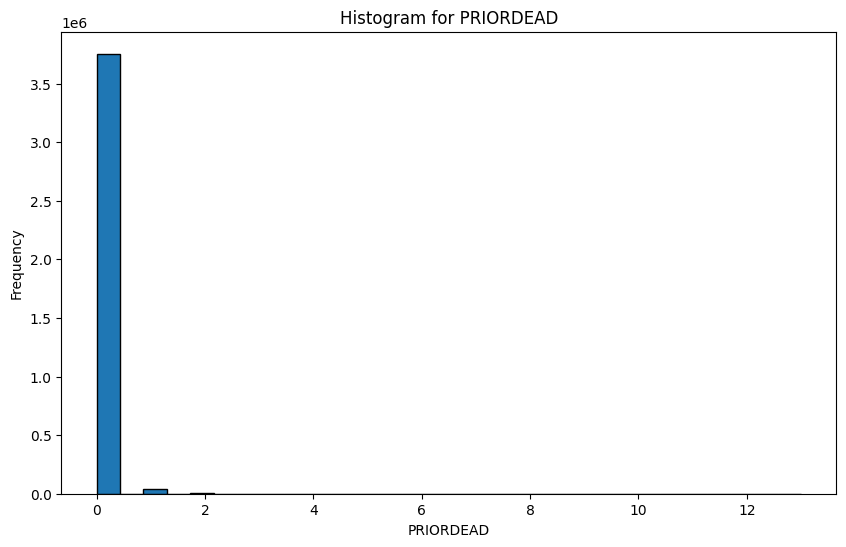

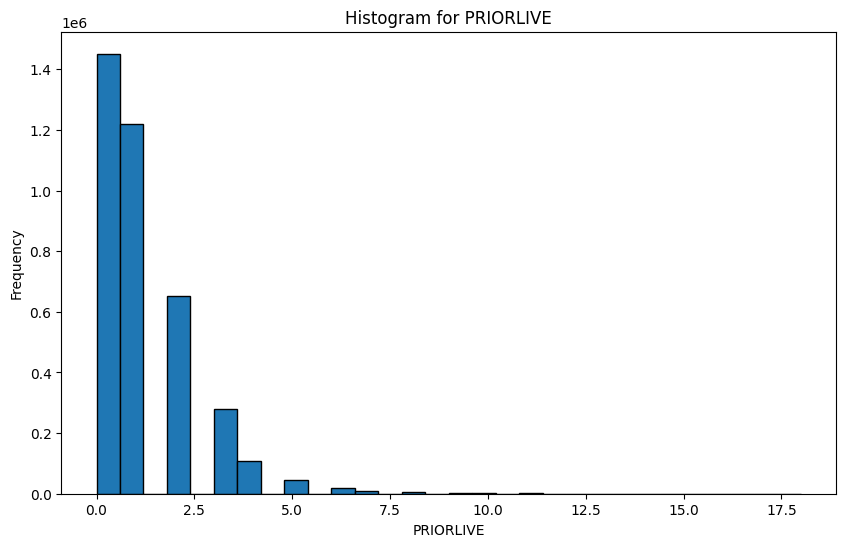

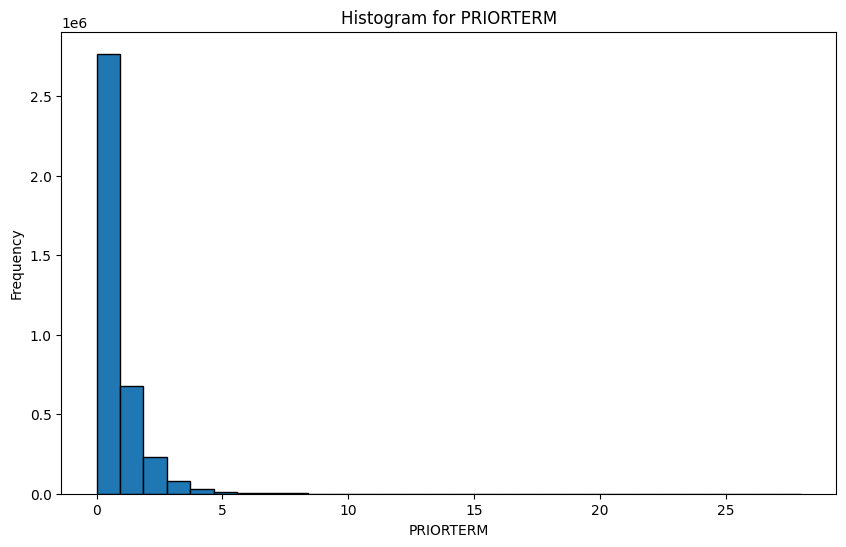

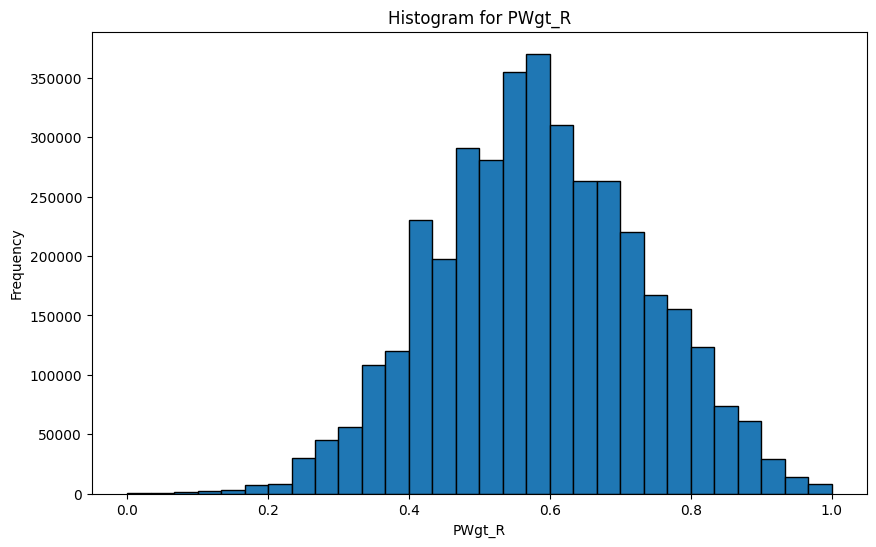

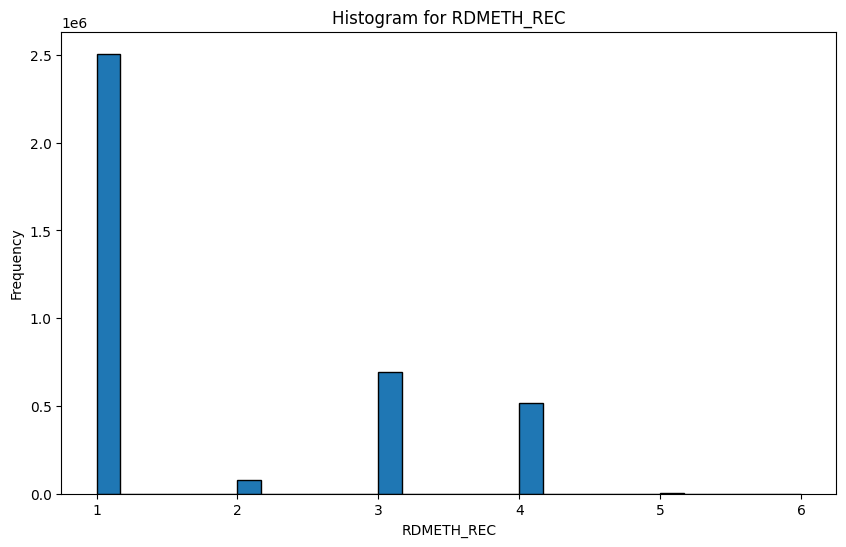

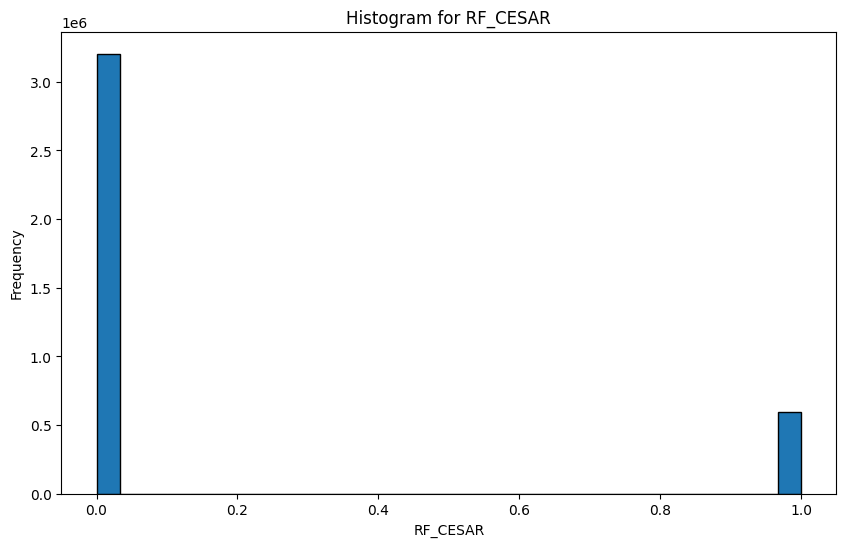

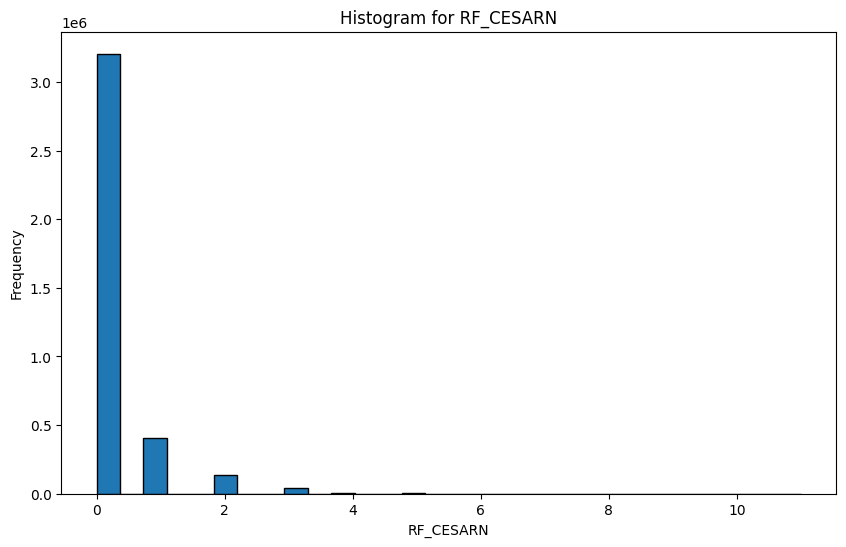

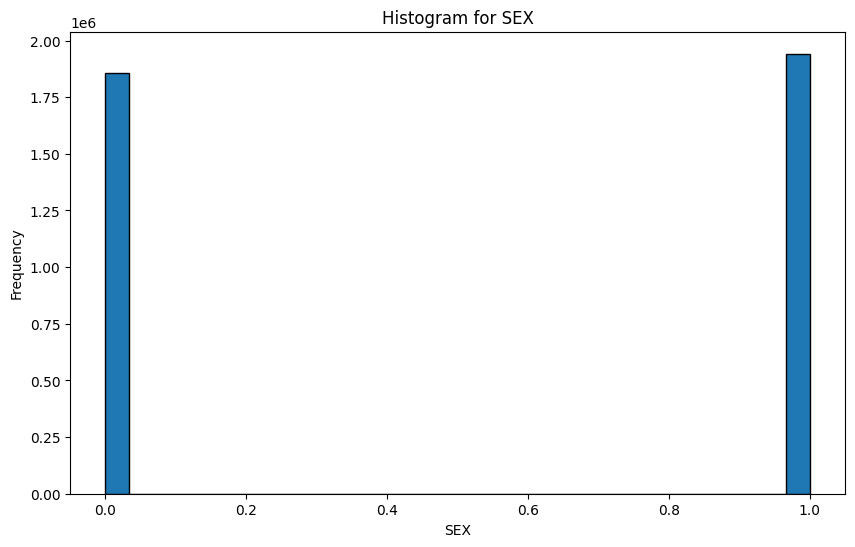

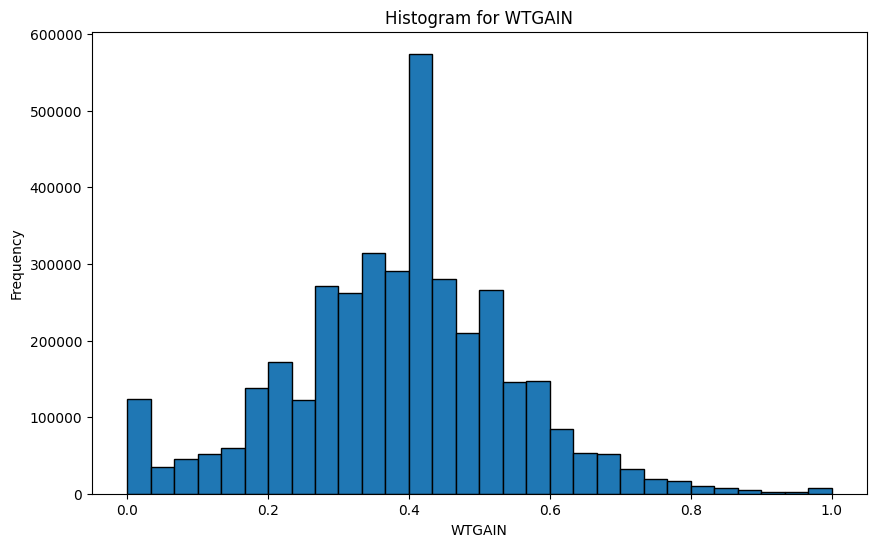

In [27]:
for column in df.columns:
    plt.figure(figsize=(10, 6))
    plt.hist(df[column], bins=30, edgecolor='black')

    plt.title(f"Histogram for {column}")
    plt.xlabel(column)
    plt.ylabel('Frequency')

    plt.show()

As you can see above, most of the frequency distributions have a bell-shaped outline, indicating that their distribution is normalized.

An important thing to note is that the target variable, i.e, the birth weights have not been normalized to preserve interpretability.

In [28]:
df.shape

(3798574, 40)

# **Building the Predictive Model**
This is most crucial part of this project.
Building a predictive model requires careful considerations to be made on the model architecture in order to produce powerful predictions.

Since we are building a PyTorch model, we will have to build a pipeline through which our data will have to flow.

We will go through each stage of the pipeline seperately.

### **Dataset Class**
We will need to wrap our data in pyTorch's Dataset class in order to use it for training.

By convention, we will have to write a few methods within a custom class that inherits the Dataset class.

In [29]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, predictor_variables, target_variables):
        self.df = df
        self.predictors = torch.tensor(df[predictor_variables].values, dtype = torch.float32)
        self.targets = torch.tensor(df[target_variables].values, dtype = torch.float32)

    def __getitem__(self, idx):
        return self.predictors[idx], self.targets[idx]

    def __len__(self):
        return self.df.shape[0]


### **Model Architecture**
We will define the model architecture by wrapping a custom class around the nn.Module class provided by pyTorch.

In [30]:
class RegressionDNN(nn.Module):
  def __init__(self, input_dim = 39):
    super(RegressionDNN, self).__init__()

    self.layer1 = nn.Linear(input_dim, 128)
    self.layer2 = nn.Linear(128, 64)
    self.layer3 = nn.Linear(64, 32)
    self.outputlayer = nn.Linear(32, 1)

  def forward(self, x):
    x = F.relu(self.layer1(x))

    x = F.relu(self.layer2(x))

    x = F.relu(self.layer3(x))

    # x = F.relu(self.layer4(x))

    output = self.outputlayer(x)
    return output


### **Training Loop**

Now we will define the training loop which uses the data to train the model.

In [31]:
def train(model, train_loader, validation_loader, optimizer, criterion, LRScheduler, epochs):
  train_losses = []
  val_losses = []
  for epoch in range(epochs):
    start_time = time.time()
    model.train()
    running_loss = 0


    for features, targets in train_loader:
      # Forward pass
      optimizer.zero_grad()
      outputs = model(features)
      loss = criterion(outputs.squeeze(), targets.squeeze())
      running_loss += loss.item()


      # Backward Pass and Optimization
      loss.backward()
      optimizer.step()
    mean_loss = running_loss/len(train_loader)


    model.eval()
    val_loss = 0
    with torch.no_grad():
      for val_features, val_targets in validation_loader:
        val_outputs = model(val_features)
        val_loss += criterion(val_outputs.squeeze(), val_targets.squeeze()).item()

    train_losses.append(mean_loss)
    val_losses.append(val_loss/len(validation_loader))
    LRScheduler.step(val_losses[-1])

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {mean_loss:.4f}, Validation Loss: {val_loss /len(validation_loader):.4f}")
    print("Elapsed Time for epoch {}: {}".format(epoch + 1, time.time() - start_time))
    print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
    print()
  return train_losses, val_losses

### **Train the Model**
Now we will train the model using the classes and functions we have defined above.

We will use the Mean Squared error as the loss metric, since this is a regression problem.

In [32]:
# Isolate the features and target variables from the dataframe
features = []
targets = []
for i in df.columns:
  if i != 'DBWT':
    features.append(i)
  else:
    targets.append(i)

In [33]:
# Wrap our data with the Custom Dataset
dataset = CustomDataset(df, features, targets)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [34]:
# Load the data
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

In [35]:
# Define the model, loss function and optimizer
model = RegressionDNN()
criterion = nn.MSELoss()
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
LRScheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 3)
epochs = 30


In [36]:
# Track total training time and begin the training loop
start_time = time.time()
train_losses, val_losses = train(model, train_loader, validation_loader, optimizer, criterion, LRScheduler, epochs)
print()
print("Total Training Time: {}".format(time.time() - start_time))

Epoch 1/30, Training Loss: 517664.7252, Validation Loss: 290397.5590
Elapsed Time for epoch 1: 89.04039549827576
Current learning rate: 0.0001

Epoch 2/30, Training Loss: 285833.7422, Validation Loss: 283476.3523
Elapsed Time for epoch 2: 88.69313621520996
Current learning rate: 0.0001

Epoch 3/30, Training Loss: 281481.6683, Validation Loss: 280068.3340
Elapsed Time for epoch 3: 89.65473508834839
Current learning rate: 0.0001

Epoch 4/30, Training Loss: 277153.3325, Validation Loss: 275287.6698
Elapsed Time for epoch 4: 89.20204210281372
Current learning rate: 0.0001

Epoch 5/30, Training Loss: 271177.9073, Validation Loss: 268289.6339
Elapsed Time for epoch 5: 89.59501791000366
Current learning rate: 0.0001

Epoch 6/30, Training Loss: 264170.0971, Validation Loss: 260557.8847
Elapsed Time for epoch 6: 89.37703680992126
Current learning rate: 0.0001

Epoch 7/30, Training Loss: 256329.3623, Validation Loss: 253574.6910
Elapsed Time for epoch 7: 90.38516521453857
Current learning rate: 

# **Evaluating Results**
Now we shall plot the loss curves to evaluate how well our model has learned from the training data

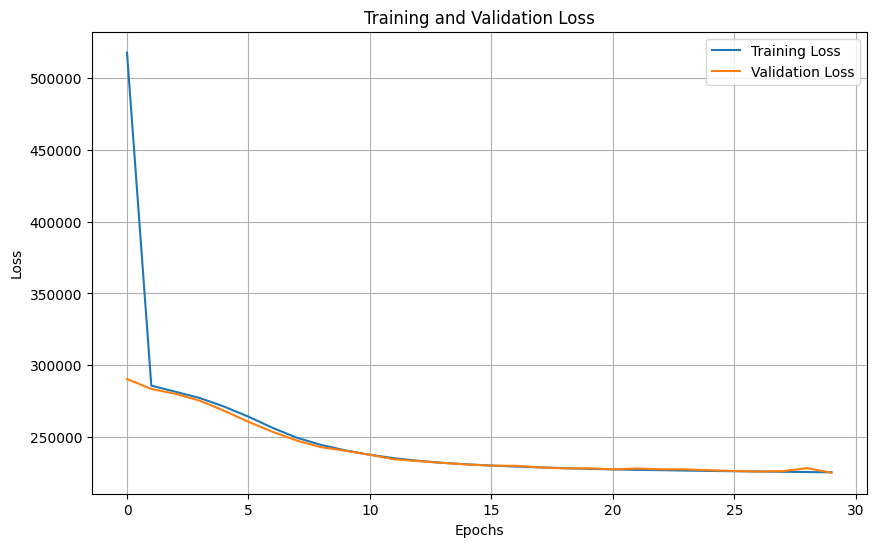

In [37]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

From the plot above, we can see that overfitting was not a problem in this scenario. The validation loss flattened throughout the training process.

To interpret the Mean Squared Error in the Validation dataset, we can employ RMSE, i.e, Root Mean Squared error.

√225133.6019 = 474.48

This implies that our predictions can on average be atmost 474 grams off from the ground truth.

With the computational resources that were available, these results seem to be pretty acceptable. I invite others to train the model from scratch for more epochs and see if the loss decrease or download the saved model from the Github repository and train it further.
The code to save the model and the cleaned dataset is given below. You can of course download both of these from the repository too.

In [38]:
torch.save(model.state_dict(), '/content/model.pth')

In [39]:
df.to_csv('/content/US_births_cleaned.csv', index=False)

# **Conclusion**
That brings us to the end of this notebook. This project took a while to complete, but it was the most fun I have had doing a project thus far!

I hope this project gave you an insight into how powerful Deep Learning techniques can be in real world ,and life changing applications, especially healthcare.
See you around!

---

## All Rights Reserved

© 2024 Abhishek Senthil Kumar. All rights reserved.

If you use this model in your research or work, please cite the following:

**Abhishek Senthil Kumar**. (2024). *Newborn Birth Weight Prediction using Deep Learning in PyTorch*. https://github.com/Abhi-61/Predicting-Birthweights-of-Newborns-in-pyTorch


